Using PIF

In [1]:
%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.insert(0,"/analysis/fabiane/phd/nitorch/")
sys.path.insert(0,"/analysis/fabiane/phd/patch_individual_filters/")

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import h5py
import nibabel as nib
# pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from nitorch.data import load_nifti
from nitorch.transforms import ToTensor
from pif import PatchIndividualFilters3D

### Parameters

Use the best model from the first outer fold. I.e. the one that we measured against the test set.

In [5]:
gpu = 3
model_dir = "/ritter/share/projects/Methods/Eitel_local_filter/experiments_submission/models/UKB/full_set/10xrandom_splits/baseline_r2/"
model_path = os.path.join(model_dir,"outer_0_inner_3_cv_fold_3_BEST_ITERATION.h5")
heatmap_dir = model_dir.replace("models", "heatmaps")

In [6]:
!mkdir -p $heatmap_dir

### Model definition

In [98]:
from experiments.models_ukb import ModelB

In [99]:
# load pre-trained weights
net = ModelB()
net.load_state_dict(torch.load(model_path, map_location='cpu'), strict=False)
net = net.cuda(gpu)
net.eval()

ModelB(
  (drop): Dropout3d(p=0.3)
  (Conv_1): Conv3d(1, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1))
  (pool_1): MaxPool3d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (Conv_2): Conv3d(8, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1))
  (pool_2): MaxPool3d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (Conv_3): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1))
  (Conv_4): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1))
  (pool_4): MaxPool3d(kernel_size=4, stride=3, padding=0, dilation=1, ceil_mode=False)
  (classifier_scratch): Sequential(
    (0): Linear(in_features=6144, out_features=100, bias=True)
    (1): ELU(alpha=1.0, inplace)
    (2): Linear(in_features=100, out_features=1, bias=True)
  )
)

In [100]:
neuron = list(dict(net.named_children())["Conv_1"].parameters())[0][0]

# Generate feature visualization through optimization

### Create starting point

In [101]:
base = torch.rand((1, 96, 114, 96))

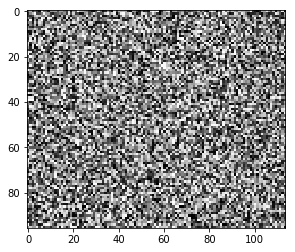

In [102]:
plt.imshow(base[0,:,:,48], cmap='gray')

Load several images

In [103]:
n_imgs = 5
table = "/ritter/share/projects/UKbiobank/Eitel_ICD/tables/participants_transMRI_T1-ICD10_G_binary-under.csv"
df = pd.read_csv(table)
# shuffle the dataset
df = df.sample(frac=1, random_state=23)

In [104]:
X = np.zeros(shape=(n_imgs, 182, 218, 182))
y = np.zeros(shape=(n_imgs))
for idx in range(n_imgs):
    path = df.iloc[idx]['file_path']
    path = path.replace("/analysis/ritter", "/ritter/share")
    image = load_nifti(path)
    X[idx] = image
    y[idx] = df.iloc[idx]['Sex'] == "Male"

In [105]:
# get nifti information of first image
path = df.iloc[idx]['file_path']
path = path.replace("/analysis/ritter", "/ritter/share")
image, nifti = load_nifti(path, incl_header=True)

In [106]:
X.shape

(5, 182, 218, 182)

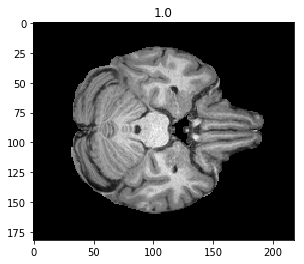

In [107]:
plt.imshow(X[1,:,:,48], cmap='gray')
plt.title(y[1])
plt.show()

In [108]:
for i, img in enumerate(X):
    X[i] = img / np.max(img) # normalize
X = torch.Tensor(X)

In [109]:
n_filters = 5

In [110]:
activation = None
class SaveActivation():
    def __init__(self, n_filters):
        self.activation = []
        self.n_filters = n_filters

    def __call__(self, module, input, output):
        print(output.data.shape)
        print(len(output.data) * self.n_filters)
        for i in range(len(output.data)):
            for j in range(self.n_filters):
                self.activation.append(output.data[i, j])
        
    def get_activation(self):
        return self.activation

In [111]:
saver = SaveActivation(n_filters)
len(saver.get_activation())

0

In [112]:
hook = net.Conv_4.register_forward_hook(saver)

In [113]:
net.forward(torch.unsqueeze(X, 1).cuda(gpu))

torch.Size([5, 64, 15, 19, 15])
25


tensor([[0.0151],
        [0.0122],
        [0.0035],
        [0.0134],
        [0.0117]], device='cuda:3', grad_fn=<AddmmBackward>)

In [114]:
len(saver.get_activation())

25

In [115]:
saver.get_activation()[0].shape

torch.Size([15, 19, 15])

In [116]:
saver.n_filters

5

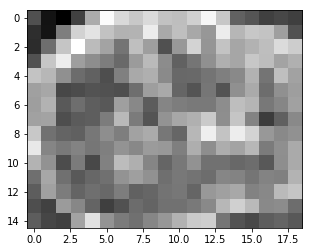

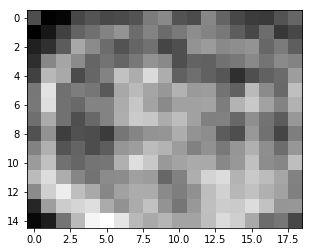

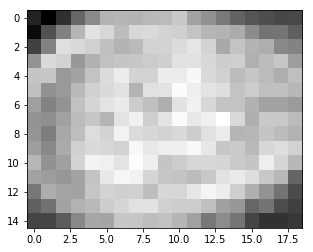

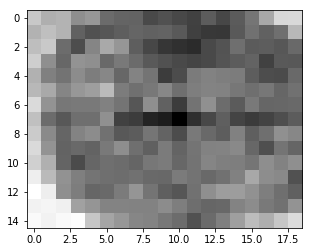

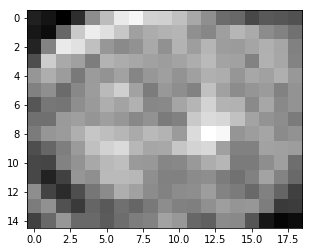

In [117]:
activation_shape = saver.get_activation()[0].shape
n_imgs = len(X)

activations = np.zeros(shape=(n_filters, )+tuple(activation_shape))

# plot sum of all images per feature
for i in range(n_imgs):
    for j in range(n_filters):
        activation = saver.get_activation()[(i*n_filters)+j].cpu().numpy()
        activations[j] += activation
        
for activation in activations:
    plt.imshow(activation[:,:,5]/n_filters, cmap='gray')
    plt.show()

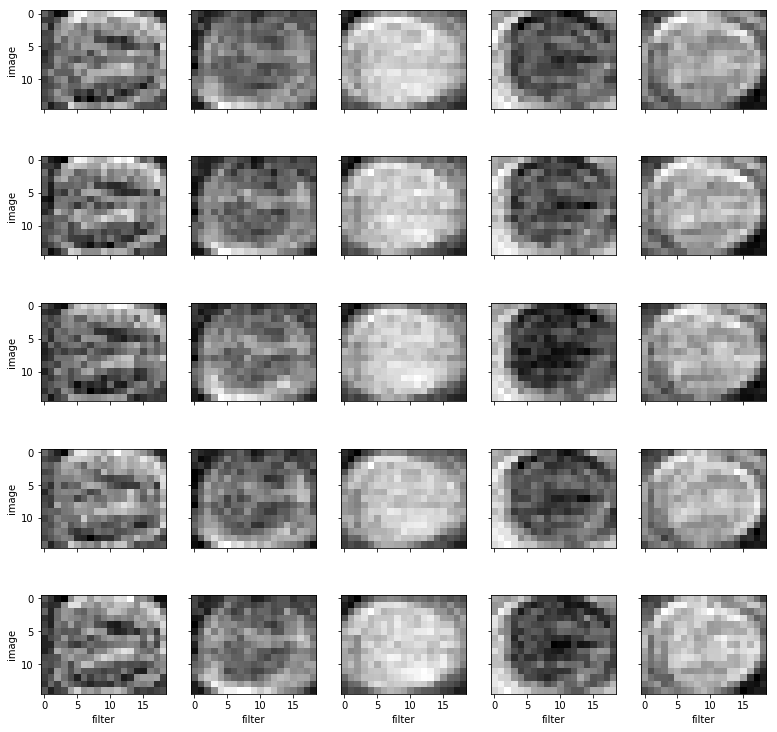

In [118]:
# Plot image/filter grid
fig, axes = plt.subplots(n_filters, n_imgs, figsize=(13, 13))
for i in range(n_imgs):
    for j in range(n_filters):
        activation = saver.get_activation()[(i*n_filters)+j].cpu().numpy()
        axes[i, j].imshow(activation[:,:,9], cmap='gray')

for ax in axes.flat:
    ax.set(xlabel='filter', ylabel='image')
    ax.label_outer()       

plt.show()

# LRP

In [119]:
sys.path.insert(0,"/analysis/fabiane/phd/Pytorch-LRP/")

In [120]:
from innvestigator import InnvestigateModel
from jrieke import interpretation

In [30]:
class FlatNet(nn.Module):
    def __init__(self, drp_rate=0.3):
        super(FlatNet, self).__init__()
        self.drp_rate = drp_rate
        self.drop = nn.Dropout3d(p=self.drp_rate)
        self.Conv_1 = nn.Conv3d(1, 8, kernel_size=3, stride=1, padding=0)
        self.pool_1 = nn.MaxPool3d(kernel_size=3, stride=3, padding=0)
        self.Conv_2 = nn.Conv3d(8, 16, kernel_size=3, stride=1, padding=0)
        self.pool_2 = nn.MaxPool3d(kernel_size=3, stride=3, padding=0)
        self.Conv_3 = nn.Conv3d(16, 32, kernel_size=3, stride=1, padding=0)
        self.Conv_4 = nn.Conv3d(32, 64, kernel_size=3, stride=1, padding=0)
        self.pool_4 = nn.MaxPool3d(kernel_size=4, stride=2, padding=0)
        self.Conv_5 = nn.Conv3d(64, 64, kernel_size=3, stride=1, padding=0)
        self.pool_5 = nn.MaxPool3d(kernel_size=4, stride=2, padding=0)

        # 4, 64, 1, 2, 1
        #self.classifier_scratch = nn.Sequential(
        self.lin_0 = nn.Linear(11200, 100)
        self.lin_1 = nn.Linear(100, 1)
        #)

    def encode(self, x, print_size=False):
        if print_size:
            print(x.shape)
        x = F.elu(self.Conv_1(x))
        h = self.drop(self.pool_1(x))
        x = F.elu(self.Conv_2(h))
        if print_size:
            print(x.shape)
        h = self.drop(self.pool_2(x))
        x = F.elu(self.Conv_3(h))
        if print_size:
            print(x.shape)
        x = F.elu(self.Conv_4(x))
        if print_size:
            print(x.shape)
        #h = self.drop(self.pool_4(x))
        x = F.elu(self.Conv_5(x)) # replace PIF with conv layer
        if print_size:
            print(x.shape)
        h = self.drop(self.pool_5(x)) 
        if print_size:
            print(h.shape)
        return h

    def forward(self, x):
        print_size = False
        x = self.encode(x, print_size=print_size)
        x = self.flatten(x)
        x = self.lin_0(x)
        x = self.lin_1(x)
        #x = self.classifier_scratch(x)
        return x
    
    def flatten(self, x):
        return x.view(x.size(0), -1)

In [121]:
# load pre-trained weights
flatnet = ModelB()
#net.load_state_dict(torch.load(model_path))
#net = net.cuda(gpu)
#net.eval()

In [122]:
flatnet

ModelB(
  (drop): Dropout3d(p=0.3)
  (Conv_1): Conv3d(1, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1))
  (pool_1): MaxPool3d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (Conv_2): Conv3d(8, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1))
  (pool_2): MaxPool3d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (Conv_3): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1))
  (Conv_4): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1))
  (pool_4): MaxPool3d(kernel_size=4, stride=3, padding=0, dilation=1, ceil_mode=False)
  (classifier_scratch): Sequential(
    (0): Linear(in_features=6144, out_features=100, bias=True)
    (1): ELU(alpha=1.0, inplace)
    (2): Linear(in_features=100, out_features=1, bias=True)
  )
)

In [123]:
new_state_dict = flatnet.state_dict()
old_state_dict = net.state_dict()
# copy conv layers
print("Start with conv layers..")
for name, param in old_state_dict.items():
    if name in new_state_dict.keys():
        print(name)
        new_state_dict[name].copy_(param)
print("Start with linear layers..")
# copy flattened dense layers
for name, param in new_state_dict.items():
    if name.startswith("lin"):
        matched_name = "classifier_scratch." + name[4:]
        print(matched_name)
        new_state_dict[name].copy_(old_state_dict[matched_name])

flatnet.load_state_dict(new_state_dict)

Start with conv layers..
Conv_1.weight
Conv_1.bias
Conv_2.weight
Conv_2.bias
Conv_3.weight
Conv_3.bias
Conv_4.weight
Conv_4.bias
classifier_scratch.0.weight
classifier_scratch.0.bias
classifier_scratch.2.weight
classifier_scratch.2.bias
Start with linear layers..


In [124]:
# prepare model for LRP
flatnet.eval()
flatnet = torch.nn.Sequential(flatnet, torch.nn.Sigmoid())
inn_model = InnvestigateModel(flatnet, lrp_exponent=1,
                              method="b-rule",
                              beta=4, epsilon=1e-6).cuda(gpu)
inn_model.eval()

InnvestigateModel(
  (model): Sequential(
    (0): ModelB(
      (drop): Dropout3d(p=0.3)
      (Conv_1): Conv3d(1, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1))
      (pool_1): MaxPool3d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
      (Conv_2): Conv3d(8, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1))
      (pool_2): MaxPool3d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
      (Conv_3): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1))
      (Conv_4): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1))
      (pool_4): MaxPool3d(kernel_size=4, stride=3, padding=0, dilation=1, ceil_mode=False)
      (classifier_scratch): Sequential(
        (0): Linear(in_features=6144, out_features=100, bias=True)
        (1): ELU(alpha=1.0, inplace)
        (2): Linear(in_features=100, out_features=1, bias=True)
      )
    )
    (1): Sigmoid()
  )
)

In [125]:
def run_LRP(net, image_tensor):
    return inn_model.innvestigate(in_tensor=image_tensor, rel_for_class=0)

In [126]:
idx = 0
AD_score, LRP_map = run_LRP(inn_model, torch.unsqueeze(torch.unsqueeze(X[idx], 0), 0).cuda(gpu))
AD_score = AD_score[0][0].detach().cpu().numpy()
LRP_map = LRP_map.detach().numpy().squeeze()

# save result on disk
lrp_layer = "score"
#res_nifti = nib.Nifti1Image(LRP_map, nifti.affine, header=nifti.header)
#nib.save(res_nifti, os.path.join(heatmap_dir, "LRP_latent-feature-map_visualization_Layer-{}.nii.gz".format(lrp_layer)))

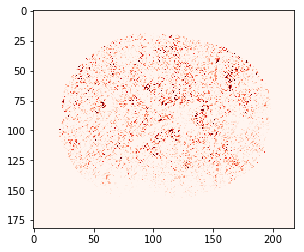

In [127]:
vmin, vmax = np.percentile(LRP_map, 90.0), np.percentile(LRP_map, 99.9)
plt.imshow(LRP_map[:,:,90], cmap='Reds', vmin=vmin, vmax=vmax)
plt.show()

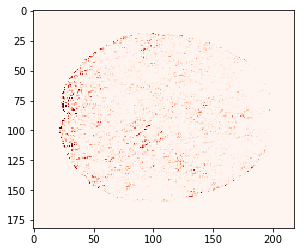

In [42]:
#vmin, vmax = np.percentile(LRP_map, 90.0), np.percentile(LRP_map, 99.9)
#plt.imshow(LRP_map[:,:,90], cmap='Reds', vmin=vmin, vmax=vmax)
#plt.show()

## old for comparison

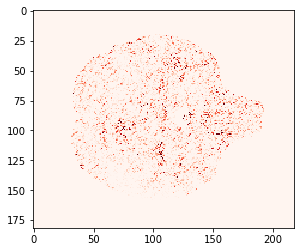

In [128]:
vmin, vmax = np.percentile(LRP_map, 90.0), np.percentile(LRP_map, 99.9)
plt.imshow(LRP_map[:,:,48], cmap='Reds', vmin=vmin, vmax=vmax)
plt.show()

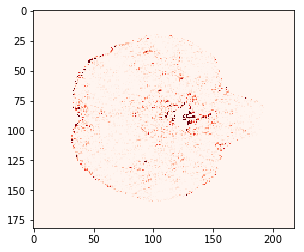

In [39]:
#vmin, vmax = np.percentile(LRP_map, 90.0), np.percentile(LRP_map, 99.9)
#plt.imshow(LRP_map[:,:,48], cmap='Reds', vmin=vmin, vmax=vmax)
#plt.show()

## old for comparison

## Use conv 4 layer as output

In [43]:
lrp_layer = "Conv4" # used only for output file naming

In [51]:
# remove flatten and classifier
class ModelBFlat(nn.Module):
    def __init__(self, drp_rate=0.3):
        super(ModelBFlat, self).__init__()
        self.drp_rate = drp_rate
        self.drop = nn.Dropout3d(p=self.drp_rate)
        self.Conv_1 = nn.Conv3d(1, 8, kernel_size=3, stride=1, padding=0)
        self.pool_1 = nn.MaxPool3d(kernel_size=3, stride=3, padding=0)
        self.Conv_2 = nn.Conv3d(8, 32, kernel_size=3, stride=1, padding=0)
        self.pool_2 = nn.MaxPool3d(kernel_size=3, stride=3, padding=0)
        self.Conv_3 = nn.Conv3d(32, 64, kernel_size=3, stride=1, padding=0)
        self.Conv_4 = nn.Conv3d(64, 64, kernel_size=3, stride=1, padding=0)
        self.pool_4 = nn.MaxPool3d(kernel_size=4, stride=3, padding=0)

        self.classifier_scratch = nn.Sequential(
            nn.Linear(6144, 100),
            nn.ELU(inplace=True),
            nn.Linear(100, 1)
        )

    def encode(self, x, print_size=False):
        if print_size:
            print(x.shape)
        x = F.elu(self.Conv_1(x))
        h = self.drop(self.pool_1(x))
        x = F.elu(self.Conv_2(h))
        if print_size:
            print(x.shape)
        h = self.drop(self.pool_2(x))
        x = F.elu(self.Conv_3(h))
        if print_size:
            print(x.shape)
        x = F.elu(self.Conv_4(x))
        if print_size:
            print(x.shape)
        h = self.drop(self.pool_4(x)) 
        return h

    def forward(self, x):
        print_size = False
        x = self.encode(x, print_size=print_size)
        #x = self.flatten(x)
        #x = self.classifier_scratch(x)
        return x
    
    def flatten(self, x):
        return x.view(x.size(0), -1)

In [52]:
# load pre-trained weights
flatnet = ModelBFlat()
#net.load_state_dict(torch.load(model_path))
#net = net.cuda(gpu)
#net.eval()

In [53]:
new_state_dict = flatnet.state_dict()
old_state_dict = net.state_dict()
# copy conv layers
print("Start with conv layers..")
for name, param in old_state_dict.items():
    if name in new_state_dict.keys():
        print(name)
        new_state_dict[name].copy_(param)
flatnet.load_state_dict(new_state_dict)

Start with conv layers..
Conv_1.weight
Conv_1.bias
Conv_2.weight
Conv_2.bias
Conv_3.weight
Conv_3.bias
Conv_4.weight
Conv_4.bias
classifier_scratch.0.weight
classifier_scratch.0.bias
classifier_scratch.2.weight
classifier_scratch.2.bias


In [54]:
# prepare model for LRP
flatnet.eval()
flatnet = torch.nn.Sequential(flatnet, torch.nn.Sigmoid())
inn_model = InnvestigateModel(flatnet, lrp_exponent=1,
                              method="b-rule",
                              beta=4, epsilon=1e-6).cuda(gpu)
inn_model.eval()

InnvestigateModel(
  (model): Sequential(
    (0): ModelBFlat(
      (drop): Dropout3d(p=0.3)
      (Conv_1): Conv3d(1, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1))
      (pool_1): MaxPool3d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
      (Conv_2): Conv3d(8, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1))
      (pool_2): MaxPool3d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
      (Conv_3): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1))
      (Conv_4): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1))
      (pool_4): MaxPool3d(kernel_size=4, stride=3, padding=0, dilation=1, ceil_mode=False)
      (classifier_scratch): Sequential(
        (0): Linear(in_features=6144, out_features=100, bias=True)
        (1): ELU(alpha=1.0, inplace)
        (2): Linear(in_features=100, out_features=1, bias=True)
      )
    )
    (1): Sigmoid()
  )
)

In [55]:
def run_LRP(net, image_tensor, output_loc=np.index_exp[:, 63, 2, 4, 3]):
    #return inn_model.innvestigate(in_tensor=image_tensor, rel_for_class=10499)
    return inn_model.innvestigate(in_tensor=image_tensor, rel_for_class=output_loc)

In [56]:
img_idx = 0
AD_score, LRP_map = run_LRP(inn_model, torch.unsqueeze(torch.unsqueeze(X[img_idx], 0), 0).cuda(gpu))
print("output shape: {}".format(AD_score.shape))
#print(AD_score[rel_for_class].shape)
#AD_score = AD_score[0][0].detach().cpu().numpy()
LRP_map = LRP_map.detach().numpy().squeeze()

output shape: torch.Size([1, 64, 4, 6, 4])


In [ ]:
print(heatmap_dir)

In [64]:
!mkdir -p $heatmap_dir

####### Next Filter #######
0 0 0
0 0 1
0 0 2
0 0 3
0 1 0
0 1 1
0 1 2
0 1 3
0 2 0
0 2 1
0 2 2
0 2 3
0 3 0
0 3 1
0 3 2
0 3 3
0 4 0
0 4 1
0 4 2
0 4 3
0 5 0
0 5 1
0 5 2
0 5 3
1 0 0
1 0 1
1 0 2
1 0 3
1 1 0
1 1 1
1 1 2
1 1 3
1 2 0
1 2 1
1 2 2
1 2 3
1 3 0
1 3 1
1 3 2
1 3 3
1 4 0
1 4 1
1 4 2
1 4 3
1 5 0
1 5 1
1 5 2
1 5 3
2 0 0
2 0 1
2 0 2
2 0 3
2 1 0
2 1 1
2 1 2
2 1 3
2 2 0
2 2 1
2 2 2
2 2 3
2 3 0
2 3 1
2 3 2
2 3 3
2 4 0
2 4 1
2 4 2
2 4 3
2 5 0
2 5 1
2 5 2
2 5 3
3 0 0
3 0 1
3 0 2
3 0 3
3 1 0
3 1 1
3 1 2
3 1 3
3 2 0
3 2 1
3 2 2
3 2 3
3 3 0
3 3 1
3 3 2
3 3 3
3 4 0
3 4 1
3 4 2
3 4 3
3 5 0
3 5 1
3 5 2
3 5 3
####### Next Filter #######
0 0 0
0 0 1
0 0 2
0 0 3
0 1 0
0 1 1
0 1 2
0 1 3
0 2 0
0 2 1
0 2 2
0 2 3
0 3 0
0 3 1
0 3 2
0 3 3
0 4 0
0 4 1
0 4 2
0 4 3
0 5 0
0 5 1
0 5 2
0 5 3
1 0 0
1 0 1
1 0 2
1 0 3
1 1 0
1 1 1
1 1 2
1 1 3
1 2 0
1 2 1
1 2 2
1 2 3
1 3 0
1 3 1
1 3 2
1 3 3
1 4 0
1 4 1
1 4 2
1 4 3
1 5 0
1 5 1
1 5 2
1 5 3
2 0 0
2 0 1
2 0 2
2 0 3
2 1 0
2 1 1
2 1 2
2 1 3
2 2 0
2 2 1
2 2 2
2 2 3
2 3 0
2 

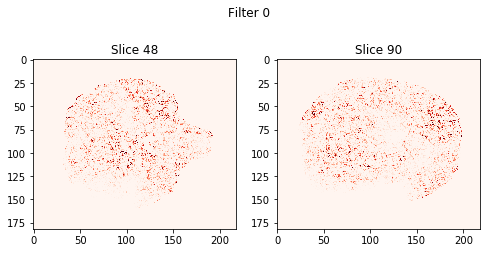

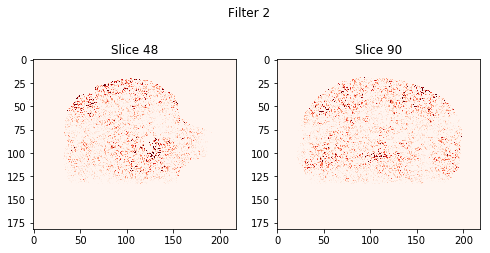

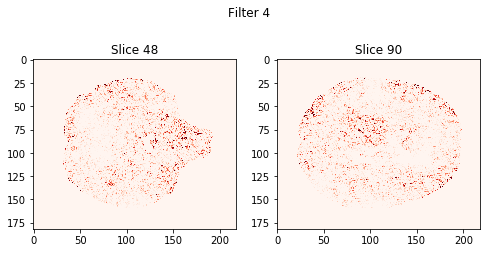

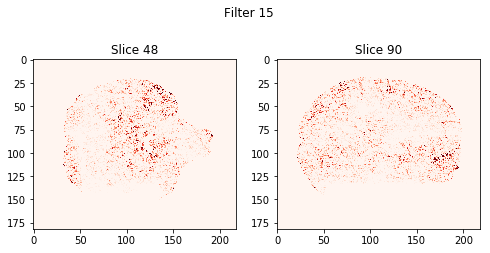

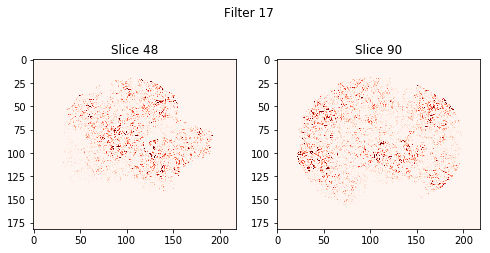

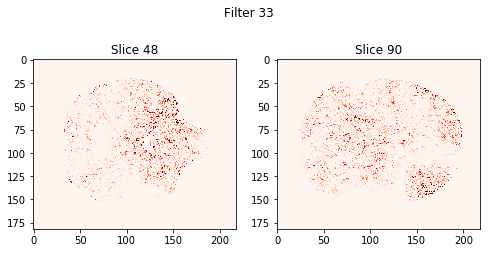

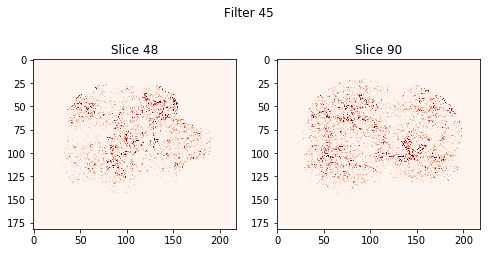

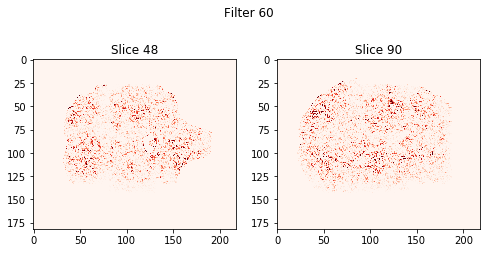

In [65]:
for filter_pos in [0, 2, 4, 15, 17, 33, 45, 60]:
    print("####### Next Filter #######")
    feature_map_shape = [4, 6, 4]
    img_idx = 0
    img = torch.unsqueeze(torch.unsqueeze(X[img_idx], 0), 0).cuda(gpu)
    LRP_maps = np.zeros(shape=X.shape[1:])
    for x in range(feature_map_shape[0]):
        for y in range(feature_map_shape[1]):
            for z in range(feature_map_shape[2]):
                print(x, y, z)
                AD_score, LRP_map = run_LRP(inn_model, 
                                            img,
                                            output_loc=np.index_exp[0, filter_pos, x, y, z])
                LRP_map = LRP_map.detach().cpu().numpy().squeeze()
                LRP_maps += LRP_map

    # visualize two slices
    fig, ax = plt.subplots(1, 2, figsize=(8, 4))
    vmin, vmax = np.percentile(LRP_maps, 90.0), np.percentile(LRP_maps, 99.9)
    ax[0].imshow(LRP_maps[:,:,48], cmap='Reds', vmin=vmin, vmax=vmax)
    ax[0].set_title("Slice 48")
    ax[1].imshow(LRP_maps[:,:,90], cmap='Reds', vmin=vmin, vmax=vmax)
    ax[1].set_title("Slice 90")
    fig.suptitle("Filter {}".format(filter_pos))
    fig.show()
    
    # save result on disk
    res_nifti = nib.Nifti1Image(LRP_maps, nifti.affine, header=nifti.header)
    nib.save(res_nifti, os.path.join(heatmap_dir, "LRP_latent-feature-map_visualization_Layer-{}_Filter-{}.nii.gz".format(lrp_layer, filter_pos)))

In [46]:
5/0

ZeroDivisionError: division by zero

In [ ]:
vmin, vmax = np.percentile(LRP_map, 90.0), np.percentile(LRP_map, 99.9)
#vmin, vmax = np.min(LRP_map), np.max(LRP_map)
plt.imshow(LRP_map[:,:,90], cmap='Reds', vmin=vmin, vmax=vmax)
plt.show()

In [ ]:
vmin, vmax = np.percentile(LRP_map, 90.0), np.percentile(LRP_map, 99.9)
#vmin, vmax = np.min(LRP_map), np.max(LRP_map)
plt.imshow(LRP_map[:,:,90], cmap='Reds', vmin=vmin, vmax=vmax)
plt.show()

In [ ]:
vmin, vmax = np.percentile(LRP_map, 90.0), np.percentile(LRP_map, 99.9)
#vmin, vmax = np.min(LRP_map), np.max(LRP_map)
plt.imshow(LRP_map[:,:,90], cmap='Reds', vmin=vmin, vmax=vmax)
plt.show()

In [ ]:
vmin, vmax = np.percentile(LRP_map, 90.0), np.percentile(LRP_map, 99.9)
#vmin, vmax = np.min(LRP_map), np.max(LRP_map)
plt.imshow(LRP_map[:,:,90], cmap='Reds', vmin=vmin, vmax=vmax)
plt.show()

In [ ]:
vmin, vmax = np.percentile(LRP_map, 90.0), np.percentile(LRP_map, 99.9)
#vmin, vmax = np.min(LRP_map), np.max(LRP_map)
plt.imshow(LRP_map[:,:,90], cmap='Reds', vmin=vmin, vmax=vmax)
plt.show()

In [ ]:
for class_idx in np.random.randint(0, 11200, size=30):
    print("Neuron {}".format(class_idx))
    def run_LRP(net, image_tensor):
        return inn_model.innvestigate(in_tensor=image_tensor, rel_for_class=class_idx)

    img_idx = 0
    AD_score, LRP_map = run_LRP(inn_model, torch.unsqueeze(torch.unsqueeze(X[img_idx], 0), 0).cuda(gpu))
    print(AD_score.shape)
    AD_score = AD_score[0][0].detach().cpu().numpy()
    LRP_map = LRP_map.detach().numpy().squeeze()

    vmin, vmax = np.percentile(LRP_map, 90.0), np.percentile(LRP_map, 99.9)
    #vmin, vmax = np.min(LRP_map), np.max(LRP_map)
    max_slice = np.argmax(np.sum(LRP_map, axis=(0,1)))
    print("Maximized slice {}".format(max_slice))
    plt.imshow(LRP_map[:,:,max_slice], cmap='Reds', vmin=vmin, vmax=vmax)
    plt.show()

## Use conv 3 layer as output

In [86]:
lrp_layer = "Conv3" # used only for output file naming

In [91]:
# remove flatten and classifier
class ModelBFlat(nn.Module):
    def __init__(self, drp_rate=0.3):
        super(ModelBFlat, self).__init__()
        self.drp_rate = drp_rate
        self.drop = nn.Dropout3d(p=self.drp_rate)
        self.Conv_1 = nn.Conv3d(1, 8, kernel_size=3, stride=1, padding=0)
        self.pool_1 = nn.MaxPool3d(kernel_size=3, stride=3, padding=0)
        self.Conv_2 = nn.Conv3d(8, 32, kernel_size=3, stride=1, padding=0)
        self.pool_2 = nn.MaxPool3d(kernel_size=3, stride=3, padding=0)
        self.Conv_3 = nn.Conv3d(32, 64, kernel_size=3, stride=1, padding=0)
        #self.Conv_4 = nn.Conv3d(64, 64, kernel_size=3, stride=1, padding=0)
        #self.pool_4 = nn.MaxPool3d(kernel_size=4, stride=3, padding=0)

        #self.classifier_scratch = nn.Sequential(
        #    nn.Linear(6144, 100),
        #    nn.ELU(inplace=True),
        #    nn.Linear(100, 1)
        #)

    def encode(self, x, print_size=False):
        if print_size:
            print(x.shape)
        x = F.elu(self.Conv_1(x))
        h = self.drop(self.pool_1(x))
        x = F.elu(self.Conv_2(h))
        if print_size:
            print(x.shape)
        h = self.drop(self.pool_2(x))
        x = F.elu(self.Conv_3(h))
        return x

    def forward(self, x):
        print_size = False
        x = self.encode(x, print_size=print_size)
        #x = self.flatten(x)
        #x = self.classifier_scratch(x)
        return x
    
    def flatten(self, x):
        return x.view(x.size(0), -1)

In [92]:
# load pre-trained weights
flatnet = ModelBFlat()
#net.load_state_dict(torch.load(model_path))
#net = net.cuda(gpu)
#net.eval()

In [93]:
new_state_dict = flatnet.state_dict()
old_state_dict = net.state_dict()
# copy conv layers
print("Start with conv layers..")
for name, param in old_state_dict.items():
    if name in new_state_dict.keys():
        print(name)
        new_state_dict[name].copy_(param)
flatnet.load_state_dict(new_state_dict)

Start with conv layers..
Conv_1.weight
Conv_1.bias
Conv_2.weight
Conv_2.bias
Conv_3.weight
Conv_3.bias


In [94]:
# prepare model for LRP
flatnet.eval()
flatnet = torch.nn.Sequential(flatnet, torch.nn.Sigmoid())
inn_model = InnvestigateModel(flatnet, lrp_exponent=1,
                              method="b-rule",
                              beta=4, epsilon=1e-6).cuda(gpu)
inn_model.eval()

InnvestigateModel(
  (model): Sequential(
    (0): ModelBFlat(
      (drop): Dropout3d(p=0.3)
      (Conv_1): Conv3d(1, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1))
      (pool_1): MaxPool3d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
      (Conv_2): Conv3d(8, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1))
      (pool_2): MaxPool3d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
      (Conv_3): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    )
    (1): Sigmoid()
  )
)

In [95]:
def run_LRP(net, image_tensor, output_loc=np.index_exp[:, 63, 2, 4, 3]):
    #return inn_model.innvestigate(in_tensor=image_tensor, rel_for_class=10499)
    return inn_model.innvestigate(in_tensor=image_tensor, rel_for_class=output_loc)

####### Next Filter #######
0 0 0
0 0 1
0 0 2
0 0 3
0 0 4
0 0 5
0 0 6
0 0 7
0 0 8
0 0 9
0 0 10
0 0 11
0 0 12
0 0 13
0 0 14
0 1 0
0 1 1
0 1 2
0 1 3
0 1 4
0 1 5
0 1 6
0 1 7
0 1 8
0 1 9
0 1 10
0 1 11
0 1 12
0 1 13
0 1 14
0 2 0
0 2 1
0 2 2
0 2 3
0 2 4
0 2 5
0 2 6
0 2 7
0 2 8
0 2 9
0 2 10
0 2 11
0 2 12
0 2 13
0 2 14
0 3 0
0 3 1
0 3 2
0 3 3
0 3 4
0 3 5
0 3 6
0 3 7
0 3 8
0 3 9
0 3 10
0 3 11
0 3 12
0 3 13
0 3 14
0 4 0
0 4 1
0 4 2
0 4 3
0 4 4
0 4 5
0 4 6
0 4 7
0 4 8
0 4 9
0 4 10
0 4 11
0 4 12
0 4 13
0 4 14
0 5 0
0 5 1
0 5 2
0 5 3
0 5 4
0 5 5
0 5 6
0 5 7
0 5 8
0 5 9
0 5 10
0 5 11
0 5 12
0 5 13
0 5 14
0 6 0
0 6 1
0 6 2
0 6 3
0 6 4
0 6 5
0 6 6
0 6 7
0 6 8
0 6 9
0 6 10
0 6 11
0 6 12
0 6 13
0 6 14
0 7 0
0 7 1
0 7 2
0 7 3
0 7 4
0 7 5
0 7 6
0 7 7
0 7 8
0 7 9
0 7 10
0 7 11
0 7 12
0 7 13
0 7 14
0 8 0
0 8 1
0 8 2
0 8 3
0 8 4
0 8 5
0 8 6
0 8 7
0 8 8
0 8 9
0 8 10
0 8 11
0 8 12
0 8 13
0 8 14
0 9 0
0 9 1
0 9 2
0 9 3
0 9 4
0 9 5
0 9 6
0 9 7
0 9 8
0 9 9
0 9 10
0 9 11
0 9 12
0 9 13
0 9 14
0 10 0
0 10 1
0 10 2
0

4 4 5
4 4 6
4 4 7
4 4 8
4 4 9
4 4 10
4 4 11
4 4 12
4 4 13
4 4 14
4 5 0
4 5 1
4 5 2
4 5 3
4 5 4
4 5 5
4 5 6
4 5 7
4 5 8
4 5 9
4 5 10
4 5 11
4 5 12
4 5 13
4 5 14
4 6 0
4 6 1
4 6 2
4 6 3
4 6 4
4 6 5
4 6 6
4 6 7
4 6 8
4 6 9
4 6 10
4 6 11
4 6 12
4 6 13
4 6 14
4 7 0
4 7 1
4 7 2
4 7 3
4 7 4
4 7 5
4 7 6
4 7 7
4 7 8
4 7 9
4 7 10
4 7 11
4 7 12
4 7 13
4 7 14
4 8 0
4 8 1
4 8 2
4 8 3
4 8 4
4 8 5
4 8 6
4 8 7
4 8 8
4 8 9
4 8 10
4 8 11
4 8 12
4 8 13
4 8 14
4 9 0
4 9 1
4 9 2
4 9 3
4 9 4
4 9 5
4 9 6
4 9 7
4 9 8
4 9 9
4 9 10
4 9 11
4 9 12
4 9 13
4 9 14
4 10 0
4 10 1
4 10 2
4 10 3
4 10 4
4 10 5
4 10 6
4 10 7
4 10 8
4 10 9
4 10 10
4 10 11
4 10 12
4 10 13
4 10 14
4 11 0
4 11 1
4 11 2
4 11 3
4 11 4
4 11 5
4 11 6
4 11 7
4 11 8
4 11 9
4 11 10
4 11 11
4 11 12
4 11 13
4 11 14
4 12 0
4 12 1
4 12 2
4 12 3
4 12 4
4 12 5
4 12 6
4 12 7
4 12 8
4 12 9
4 12 10
4 12 11
4 12 12
4 12 13
4 12 14
4 13 0
4 13 1
4 13 2
4 13 3
4 13 4
4 13 5
4 13 6
4 13 7
4 13 8
4 13 9
4 13 10
4 13 11
4 13 12
4 13 13
4 13 14
4 14 0
4 14 1
4 14 2

8 8 14
8 9 0
8 9 1
8 9 2
8 9 3
8 9 4
8 9 5
8 9 6
8 9 7
8 9 8
8 9 9
8 9 10
8 9 11
8 9 12
8 9 13
8 9 14
8 10 0
8 10 1
8 10 2
8 10 3
8 10 4
8 10 5
8 10 6
8 10 7
8 10 8
8 10 9
8 10 10
8 10 11
8 10 12
8 10 13
8 10 14
8 11 0
8 11 1
8 11 2
8 11 3
8 11 4
8 11 5
8 11 6
8 11 7
8 11 8
8 11 9
8 11 10
8 11 11
8 11 12
8 11 13
8 11 14
8 12 0
8 12 1
8 12 2
8 12 3
8 12 4
8 12 5
8 12 6
8 12 7
8 12 8
8 12 9
8 12 10
8 12 11
8 12 12
8 12 13
8 12 14
8 13 0
8 13 1
8 13 2
8 13 3
8 13 4
8 13 5
8 13 6
8 13 7
8 13 8
8 13 9
8 13 10
8 13 11
8 13 12
8 13 13
8 13 14
8 14 0
8 14 1
8 14 2
8 14 3
8 14 4
8 14 5
8 14 6
8 14 7
8 14 8
8 14 9
8 14 10
8 14 11
8 14 12
8 14 13
8 14 14
8 15 0
8 15 1
8 15 2
8 15 3
8 15 4
8 15 5
8 15 6
8 15 7
8 15 8
8 15 9
8 15 10
8 15 11
8 15 12
8 15 13
8 15 14
8 16 0
8 16 1
8 16 2
8 16 3
8 16 4
8 16 5
8 16 6
8 16 7
8 16 8
8 16 9
8 16 10
8 16 11
8 16 12
8 16 13
8 16 14
8 17 0
8 17 1
8 17 2
8 17 3
8 17 4
8 17 5
8 17 6
8 17 7
8 17 8
8 17 9
8 17 10
8 17 11
8 17 12
8 17 13
8 17 14
8 18 0
8 18 1
8 18

12 6 8
12 6 9
12 6 10
12 6 11
12 6 12
12 6 13
12 6 14
12 7 0
12 7 1
12 7 2
12 7 3
12 7 4
12 7 5
12 7 6
12 7 7
12 7 8
12 7 9
12 7 10
12 7 11
12 7 12
12 7 13
12 7 14
12 8 0
12 8 1
12 8 2
12 8 3
12 8 4
12 8 5
12 8 6
12 8 7
12 8 8
12 8 9
12 8 10
12 8 11
12 8 12
12 8 13
12 8 14
12 9 0
12 9 1
12 9 2
12 9 3
12 9 4
12 9 5
12 9 6
12 9 7
12 9 8
12 9 9
12 9 10
12 9 11
12 9 12
12 9 13
12 9 14
12 10 0
12 10 1
12 10 2
12 10 3
12 10 4
12 10 5
12 10 6
12 10 7
12 10 8
12 10 9
12 10 10
12 10 11
12 10 12
12 10 13
12 10 14
12 11 0
12 11 1
12 11 2
12 11 3
12 11 4
12 11 5
12 11 6
12 11 7
12 11 8
12 11 9
12 11 10
12 11 11
12 11 12
12 11 13
12 11 14
12 12 0
12 12 1
12 12 2
12 12 3
12 12 4
12 12 5
12 12 6
12 12 7
12 12 8
12 12 9
12 12 10
12 12 11
12 12 12
12 12 13
12 12 14
12 13 0
12 13 1
12 13 2
12 13 3
12 13 4
12 13 5
12 13 6
12 13 7
12 13 8
12 13 9
12 13 10
12 13 11
12 13 12
12 13 13
12 13 14
12 14 0
12 14 1
12 14 2
12 14 3
12 14 4
12 14 5
12 14 6
12 14 7
12 14 8
12 14 9
12 14 10
12 14 11
12 14 12
12 14 13


1 2 13
1 2 14
1 3 0
1 3 1
1 3 2
1 3 3
1 3 4
1 3 5
1 3 6
1 3 7
1 3 8
1 3 9
1 3 10
1 3 11
1 3 12
1 3 13
1 3 14
1 4 0
1 4 1
1 4 2
1 4 3
1 4 4
1 4 5
1 4 6
1 4 7
1 4 8
1 4 9
1 4 10
1 4 11
1 4 12
1 4 13
1 4 14
1 5 0
1 5 1
1 5 2
1 5 3
1 5 4
1 5 5
1 5 6
1 5 7
1 5 8
1 5 9
1 5 10
1 5 11
1 5 12
1 5 13
1 5 14
1 6 0
1 6 1
1 6 2
1 6 3
1 6 4
1 6 5
1 6 6
1 6 7
1 6 8
1 6 9
1 6 10
1 6 11
1 6 12
1 6 13
1 6 14
1 7 0
1 7 1
1 7 2
1 7 3
1 7 4
1 7 5
1 7 6
1 7 7
1 7 8
1 7 9
1 7 10
1 7 11
1 7 12
1 7 13
1 7 14
1 8 0
1 8 1
1 8 2
1 8 3
1 8 4
1 8 5
1 8 6
1 8 7
1 8 8
1 8 9
1 8 10
1 8 11
1 8 12
1 8 13
1 8 14
1 9 0
1 9 1
1 9 2
1 9 3
1 9 4
1 9 5
1 9 6
1 9 7
1 9 8
1 9 9
1 9 10
1 9 11
1 9 12
1 9 13
1 9 14
1 10 0
1 10 1
1 10 2
1 10 3
1 10 4
1 10 5
1 10 6
1 10 7
1 10 8
1 10 9
1 10 10
1 10 11
1 10 12
1 10 13
1 10 14
1 11 0
1 11 1
1 11 2
1 11 3
1 11 4
1 11 5
1 11 6
1 11 7
1 11 8
1 11 9
1 11 10
1 11 11
1 11 12
1 11 13
1 11 14
1 12 0
1 12 1
1 12 2
1 12 3
1 12 4
1 12 5
1 12 6
1 12 7
1 12 8
1 12 9
1 12 10
1 12 11
1 12 12
1 12 13

5 7 7
5 7 8
5 7 9
5 7 10
5 7 11
5 7 12
5 7 13
5 7 14
5 8 0
5 8 1
5 8 2
5 8 3
5 8 4
5 8 5
5 8 6
5 8 7
5 8 8
5 8 9
5 8 10
5 8 11
5 8 12
5 8 13
5 8 14
5 9 0
5 9 1
5 9 2
5 9 3
5 9 4
5 9 5
5 9 6
5 9 7
5 9 8
5 9 9
5 9 10
5 9 11
5 9 12
5 9 13
5 9 14
5 10 0
5 10 1
5 10 2
5 10 3
5 10 4
5 10 5
5 10 6
5 10 7
5 10 8
5 10 9
5 10 10
5 10 11
5 10 12
5 10 13
5 10 14
5 11 0
5 11 1
5 11 2
5 11 3
5 11 4
5 11 5
5 11 6
5 11 7
5 11 8
5 11 9
5 11 10
5 11 11
5 11 12
5 11 13
5 11 14
5 12 0
5 12 1
5 12 2
5 12 3
5 12 4
5 12 5
5 12 6
5 12 7
5 12 8
5 12 9
5 12 10
5 12 11
5 12 12
5 12 13
5 12 14
5 13 0
5 13 1
5 13 2
5 13 3
5 13 4
5 13 5
5 13 6
5 13 7
5 13 8
5 13 9
5 13 10
5 13 11
5 13 12
5 13 13
5 13 14
5 14 0
5 14 1
5 14 2
5 14 3
5 14 4
5 14 5
5 14 6
5 14 7
5 14 8
5 14 9
5 14 10
5 14 11
5 14 12
5 14 13
5 14 14
5 15 0
5 15 1
5 15 2
5 15 3
5 15 4
5 15 5
5 15 6
5 15 7
5 15 8
5 15 9
5 15 10
5 15 11
5 15 12
5 15 13
5 15 14
5 16 0
5 16 1
5 16 2
5 16 3
5 16 4
5 16 5
5 16 6
5 16 7
5 16 8
5 16 9
5 16 10
5 16 11
5 16 12
5 1

9 11 12
9 11 13
9 11 14
9 12 0
9 12 1
9 12 2
9 12 3
9 12 4
9 12 5
9 12 6
9 12 7
9 12 8
9 12 9
9 12 10
9 12 11
9 12 12
9 12 13
9 12 14
9 13 0
9 13 1
9 13 2
9 13 3
9 13 4
9 13 5
9 13 6
9 13 7
9 13 8
9 13 9
9 13 10
9 13 11
9 13 12
9 13 13
9 13 14
9 14 0
9 14 1
9 14 2
9 14 3
9 14 4
9 14 5
9 14 6
9 14 7
9 14 8
9 14 9
9 14 10
9 14 11
9 14 12
9 14 13
9 14 14
9 15 0
9 15 1
9 15 2
9 15 3
9 15 4
9 15 5
9 15 6
9 15 7
9 15 8
9 15 9
9 15 10
9 15 11
9 15 12
9 15 13
9 15 14
9 16 0
9 16 1
9 16 2
9 16 3
9 16 4
9 16 5
9 16 6
9 16 7
9 16 8
9 16 9
9 16 10
9 16 11
9 16 12
9 16 13
9 16 14
9 17 0
9 17 1
9 17 2
9 17 3
9 17 4
9 17 5
9 17 6
9 17 7
9 17 8
9 17 9
9 17 10
9 17 11
9 17 12
9 17 13
9 17 14
9 18 0
9 18 1
9 18 2
9 18 3
9 18 4
9 18 5
9 18 6
9 18 7
9 18 8
9 18 9
9 18 10
9 18 11
9 18 12
9 18 13
9 18 14
10 0 0
10 0 1
10 0 2
10 0 3
10 0 4
10 0 5
10 0 6
10 0 7
10 0 8
10 0 9
10 0 10
10 0 11
10 0 12
10 0 13
10 0 14
10 1 0
10 1 1
10 1 2
10 1 3
10 1 4
10 1 5
10 1 6
10 1 7
10 1 8
10 1 9
10 1 10
10 1 11
10 1 12
10

13 6 10
13 6 11
13 6 12
13 6 13
13 6 14
13 7 0
13 7 1
13 7 2
13 7 3
13 7 4
13 7 5
13 7 6
13 7 7
13 7 8
13 7 9
13 7 10
13 7 11
13 7 12
13 7 13
13 7 14
13 8 0
13 8 1
13 8 2
13 8 3
13 8 4
13 8 5
13 8 6
13 8 7
13 8 8
13 8 9
13 8 10
13 8 11
13 8 12
13 8 13
13 8 14
13 9 0
13 9 1
13 9 2
13 9 3
13 9 4
13 9 5
13 9 6
13 9 7
13 9 8
13 9 9
13 9 10
13 9 11
13 9 12
13 9 13
13 9 14
13 10 0
13 10 1
13 10 2
13 10 3
13 10 4
13 10 5
13 10 6
13 10 7
13 10 8
13 10 9
13 10 10
13 10 11
13 10 12
13 10 13
13 10 14
13 11 0
13 11 1
13 11 2
13 11 3
13 11 4
13 11 5
13 11 6
13 11 7
13 11 8
13 11 9
13 11 10
13 11 11
13 11 12
13 11 13
13 11 14
13 12 0
13 12 1
13 12 2
13 12 3
13 12 4
13 12 5
13 12 6
13 12 7
13 12 8
13 12 9
13 12 10
13 12 11
13 12 12
13 12 13
13 12 14
13 13 0
13 13 1
13 13 2
13 13 3
13 13 4
13 13 5
13 13 6
13 13 7
13 13 8
13 13 9
13 13 10
13 13 11
13 13 12
13 13 13
13 13 14
13 14 0
13 14 1
13 14 2
13 14 3
13 14 4
13 14 5
13 14 6
13 14 7
13 14 8
13 14 9
13 14 10
13 14 11
13 14 12
13 14 13
13 14 14
13 15

2 6 0
2 6 1
2 6 2
2 6 3
2 6 4
2 6 5
2 6 6
2 6 7
2 6 8
2 6 9
2 6 10
2 6 11
2 6 12
2 6 13
2 6 14
2 7 0
2 7 1
2 7 2
2 7 3
2 7 4
2 7 5
2 7 6
2 7 7
2 7 8
2 7 9
2 7 10
2 7 11
2 7 12
2 7 13
2 7 14
2 8 0
2 8 1
2 8 2
2 8 3
2 8 4
2 8 5
2 8 6
2 8 7
2 8 8
2 8 9
2 8 10
2 8 11
2 8 12
2 8 13
2 8 14
2 9 0
2 9 1
2 9 2
2 9 3
2 9 4
2 9 5
2 9 6
2 9 7
2 9 8
2 9 9
2 9 10
2 9 11
2 9 12
2 9 13
2 9 14
2 10 0
2 10 1
2 10 2
2 10 3
2 10 4
2 10 5
2 10 6
2 10 7
2 10 8
2 10 9
2 10 10
2 10 11
2 10 12
2 10 13
2 10 14
2 11 0
2 11 1
2 11 2
2 11 3
2 11 4
2 11 5
2 11 6
2 11 7
2 11 8
2 11 9
2 11 10
2 11 11
2 11 12
2 11 13
2 11 14
2 12 0
2 12 1
2 12 2
2 12 3
2 12 4
2 12 5
2 12 6
2 12 7
2 12 8
2 12 9
2 12 10
2 12 11
2 12 12
2 12 13
2 12 14
2 13 0
2 13 1
2 13 2
2 13 3
2 13 4
2 13 5
2 13 6
2 13 7
2 13 8
2 13 9
2 13 10
2 13 11
2 13 12
2 13 13
2 13 14
2 14 0
2 14 1
2 14 2
2 14 3
2 14 4
2 14 5
2 14 6
2 14 7
2 14 8
2 14 9
2 14 10
2 14 11
2 14 12
2 14 13
2 14 14
2 15 0
2 15 1
2 15 2
2 15 3
2 15 4
2 15 5
2 15 6
2 15 7
2 15 8
2 15 9


6 10 8
6 10 9
6 10 10
6 10 11
6 10 12
6 10 13
6 10 14
6 11 0
6 11 1
6 11 2
6 11 3
6 11 4
6 11 5
6 11 6
6 11 7
6 11 8
6 11 9
6 11 10
6 11 11
6 11 12
6 11 13
6 11 14
6 12 0
6 12 1
6 12 2
6 12 3
6 12 4
6 12 5
6 12 6
6 12 7
6 12 8
6 12 9
6 12 10
6 12 11
6 12 12
6 12 13
6 12 14
6 13 0
6 13 1
6 13 2
6 13 3
6 13 4
6 13 5
6 13 6
6 13 7
6 13 8
6 13 9
6 13 10
6 13 11
6 13 12
6 13 13
6 13 14
6 14 0
6 14 1
6 14 2
6 14 3
6 14 4
6 14 5
6 14 6
6 14 7
6 14 8
6 14 9
6 14 10
6 14 11
6 14 12
6 14 13
6 14 14
6 15 0
6 15 1
6 15 2
6 15 3
6 15 4
6 15 5
6 15 6
6 15 7
6 15 8
6 15 9
6 15 10
6 15 11
6 15 12
6 15 13
6 15 14
6 16 0
6 16 1
6 16 2
6 16 3
6 16 4
6 16 5
6 16 6
6 16 7
6 16 8
6 16 9
6 16 10
6 16 11
6 16 12
6 16 13
6 16 14
6 17 0
6 17 1
6 17 2
6 17 3
6 17 4
6 17 5
6 17 6
6 17 7
6 17 8
6 17 9
6 17 10
6 17 11
6 17 12
6 17 13
6 17 14
6 18 0
6 18 1
6 18 2
6 18 3
6 18 4
6 18 5
6 18 6
6 18 7
6 18 8
6 18 9
6 18 10
6 18 11
6 18 12
6 18 13
6 18 14
7 0 0
7 0 1
7 0 2
7 0 3
7 0 4
7 0 5
7 0 6
7 0 7
7 0 8
7 0 9
7 0 10

10 12 11
10 12 12
10 12 13
10 12 14
10 13 0
10 13 1
10 13 2
10 13 3
10 13 4
10 13 5
10 13 6
10 13 7
10 13 8
10 13 9
10 13 10
10 13 11
10 13 12
10 13 13
10 13 14
10 14 0
10 14 1
10 14 2
10 14 3
10 14 4
10 14 5
10 14 6
10 14 7
10 14 8
10 14 9
10 14 10
10 14 11
10 14 12
10 14 13
10 14 14
10 15 0
10 15 1
10 15 2
10 15 3
10 15 4
10 15 5
10 15 6
10 15 7
10 15 8
10 15 9
10 15 10
10 15 11
10 15 12
10 15 13
10 15 14
10 16 0
10 16 1
10 16 2
10 16 3
10 16 4
10 16 5
10 16 6
10 16 7
10 16 8
10 16 9
10 16 10
10 16 11
10 16 12
10 16 13
10 16 14
10 17 0
10 17 1
10 17 2
10 17 3
10 17 4
10 17 5
10 17 6
10 17 7
10 17 8
10 17 9
10 17 10
10 17 11
10 17 12
10 17 13
10 17 14
10 18 0
10 18 1
10 18 2
10 18 3
10 18 4
10 18 5
10 18 6
10 18 7
10 18 8
10 18 9
10 18 10
10 18 11
10 18 12
10 18 13
10 18 14
11 0 0
11 0 1
11 0 2
11 0 3
11 0 4
11 0 5
11 0 6
11 0 7
11 0 8
11 0 9
11 0 10
11 0 11
11 0 12
11 0 13
11 0 14
11 1 0
11 1 1
11 1 2
11 1 3
11 1 4
11 1 5
11 1 6
11 1 7
11 1 8
11 1 9
11 1 10
11 1 11
11 1 12
11 1 13
11

14 6 11
14 6 12
14 6 13
14 6 14
14 7 0
14 7 1
14 7 2
14 7 3
14 7 4
14 7 5
14 7 6
14 7 7
14 7 8
14 7 9
14 7 10
14 7 11
14 7 12
14 7 13
14 7 14
14 8 0
14 8 1
14 8 2
14 8 3
14 8 4
14 8 5
14 8 6
14 8 7
14 8 8
14 8 9
14 8 10
14 8 11
14 8 12
14 8 13
14 8 14
14 9 0
14 9 1
14 9 2
14 9 3
14 9 4
14 9 5
14 9 6
14 9 7
14 9 8
14 9 9
14 9 10
14 9 11
14 9 12
14 9 13
14 9 14
14 10 0
14 10 1
14 10 2
14 10 3
14 10 4
14 10 5
14 10 6
14 10 7
14 10 8
14 10 9
14 10 10
14 10 11
14 10 12
14 10 13
14 10 14
14 11 0
14 11 1
14 11 2
14 11 3
14 11 4
14 11 5
14 11 6
14 11 7
14 11 8
14 11 9
14 11 10
14 11 11
14 11 12
14 11 13
14 11 14
14 12 0
14 12 1
14 12 2
14 12 3
14 12 4
14 12 5
14 12 6
14 12 7
14 12 8
14 12 9
14 12 10
14 12 11
14 12 12
14 12 13
14 12 14
14 13 0
14 13 1
14 13 2
14 13 3
14 13 4
14 13 5
14 13 6
14 13 7
14 13 8
14 13 9
14 13 10
14 13 11
14 13 12
14 13 13
14 13 14
14 14 0
14 14 1
14 14 2
14 14 3
14 14 4
14 14 5
14 14 6
14 14 7
14 14 8
14 14 9
14 14 10
14 14 11
14 14 12
14 14 13
14 14 14
14 15 0
14 15

3 9 1
3 9 2
3 9 3
3 9 4
3 9 5
3 9 6
3 9 7
3 9 8
3 9 9
3 9 10
3 9 11
3 9 12
3 9 13
3 9 14
3 10 0
3 10 1
3 10 2
3 10 3
3 10 4
3 10 5
3 10 6
3 10 7
3 10 8
3 10 9
3 10 10
3 10 11
3 10 12
3 10 13
3 10 14
3 11 0
3 11 1
3 11 2
3 11 3
3 11 4
3 11 5
3 11 6
3 11 7
3 11 8
3 11 9
3 11 10
3 11 11
3 11 12
3 11 13
3 11 14
3 12 0
3 12 1
3 12 2
3 12 3
3 12 4
3 12 5
3 12 6
3 12 7
3 12 8
3 12 9
3 12 10
3 12 11
3 12 12
3 12 13
3 12 14
3 13 0
3 13 1
3 13 2
3 13 3
3 13 4
3 13 5
3 13 6
3 13 7
3 13 8
3 13 9
3 13 10
3 13 11
3 13 12
3 13 13
3 13 14
3 14 0
3 14 1
3 14 2
3 14 3
3 14 4
3 14 5
3 14 6
3 14 7
3 14 8
3 14 9
3 14 10
3 14 11
3 14 12
3 14 13
3 14 14
3 15 0
3 15 1
3 15 2
3 15 3
3 15 4
3 15 5
3 15 6
3 15 7
3 15 8
3 15 9
3 15 10
3 15 11
3 15 12
3 15 13
3 15 14
3 16 0
3 16 1
3 16 2
3 16 3
3 16 4
3 16 5
3 16 6
3 16 7
3 16 8
3 16 9
3 16 10
3 16 11
3 16 12
3 16 13
3 16 14
3 17 0
3 17 1
3 17 2
3 17 3
3 17 4
3 17 5
3 17 6
3 17 7
3 17 8
3 17 9
3 17 10
3 17 11
3 17 12
3 17 13
3 17 14
3 18 0
3 18 1
3 18 2
3 18 3
3 1

7 13 2
7 13 3
7 13 4
7 13 5
7 13 6
7 13 7
7 13 8
7 13 9
7 13 10
7 13 11
7 13 12
7 13 13
7 13 14
7 14 0
7 14 1
7 14 2
7 14 3
7 14 4
7 14 5
7 14 6
7 14 7
7 14 8
7 14 9
7 14 10
7 14 11
7 14 12
7 14 13
7 14 14
7 15 0
7 15 1
7 15 2
7 15 3
7 15 4
7 15 5
7 15 6
7 15 7
7 15 8
7 15 9
7 15 10
7 15 11
7 15 12
7 15 13
7 15 14
7 16 0
7 16 1
7 16 2
7 16 3
7 16 4
7 16 5
7 16 6
7 16 7
7 16 8
7 16 9
7 16 10
7 16 11
7 16 12
7 16 13
7 16 14
7 17 0
7 17 1
7 17 2
7 17 3
7 17 4
7 17 5
7 17 6
7 17 7
7 17 8
7 17 9
7 17 10
7 17 11
7 17 12
7 17 13
7 17 14
7 18 0
7 18 1
7 18 2
7 18 3
7 18 4
7 18 5
7 18 6
7 18 7
7 18 8
7 18 9
7 18 10
7 18 11
7 18 12
7 18 13
7 18 14
8 0 0
8 0 1
8 0 2
8 0 3
8 0 4
8 0 5
8 0 6
8 0 7
8 0 8
8 0 9
8 0 10
8 0 11
8 0 12
8 0 13
8 0 14
8 1 0
8 1 1
8 1 2
8 1 3
8 1 4
8 1 5
8 1 6
8 1 7
8 1 8
8 1 9
8 1 10
8 1 11
8 1 12
8 1 13
8 1 14
8 2 0
8 2 1
8 2 2
8 2 3
8 2 4
8 2 5
8 2 6
8 2 7
8 2 8
8 2 9
8 2 10
8 2 11
8 2 12
8 2 13
8 2 14
8 3 0
8 3 1
8 3 2
8 3 3
8 3 4
8 3 5
8 3 6
8 3 7
8 3 8
8 3 9
8 3 10
8 

11 12 12
11 12 13
11 12 14
11 13 0
11 13 1
11 13 2
11 13 3
11 13 4
11 13 5
11 13 6
11 13 7
11 13 8
11 13 9
11 13 10
11 13 11
11 13 12
11 13 13
11 13 14
11 14 0
11 14 1
11 14 2
11 14 3
11 14 4
11 14 5
11 14 6
11 14 7
11 14 8
11 14 9
11 14 10
11 14 11
11 14 12
11 14 13
11 14 14
11 15 0
11 15 1
11 15 2
11 15 3
11 15 4
11 15 5
11 15 6
11 15 7
11 15 8
11 15 9
11 15 10
11 15 11
11 15 12
11 15 13
11 15 14
11 16 0
11 16 1
11 16 2
11 16 3
11 16 4
11 16 5
11 16 6
11 16 7
11 16 8
11 16 9
11 16 10
11 16 11
11 16 12
11 16 13
11 16 14
11 17 0
11 17 1
11 17 2
11 17 3
11 17 4
11 17 5
11 17 6
11 17 7
11 17 8
11 17 9
11 17 10
11 17 11
11 17 12
11 17 13
11 17 14
11 18 0
11 18 1
11 18 2
11 18 3
11 18 4
11 18 5
11 18 6
11 18 7
11 18 8
11 18 9
11 18 10
11 18 11
11 18 12
11 18 13
11 18 14
12 0 0
12 0 1
12 0 2
12 0 3
12 0 4
12 0 5
12 0 6
12 0 7
12 0 8
12 0 9
12 0 10
12 0 11
12 0 12
12 0 13
12 0 14
12 1 0
12 1 1
12 1 2
12 1 3
12 1 4
12 1 5
12 1 6
12 1 7
12 1 8
12 1 9
12 1 10
12 1 11
12 1 12
12 1 13
12 1 14
12 

0 7 8
0 7 9
0 7 10
0 7 11
0 7 12
0 7 13
0 7 14
0 8 0
0 8 1
0 8 2
0 8 3
0 8 4
0 8 5
0 8 6
0 8 7
0 8 8
0 8 9
0 8 10
0 8 11
0 8 12
0 8 13
0 8 14
0 9 0
0 9 1
0 9 2
0 9 3
0 9 4
0 9 5
0 9 6
0 9 7
0 9 8
0 9 9
0 9 10
0 9 11
0 9 12
0 9 13
0 9 14
0 10 0
0 10 1
0 10 2
0 10 3
0 10 4
0 10 5
0 10 6
0 10 7
0 10 8
0 10 9
0 10 10
0 10 11
0 10 12
0 10 13
0 10 14
0 11 0
0 11 1
0 11 2
0 11 3
0 11 4
0 11 5
0 11 6
0 11 7
0 11 8
0 11 9
0 11 10
0 11 11
0 11 12
0 11 13
0 11 14
0 12 0
0 12 1
0 12 2
0 12 3
0 12 4
0 12 5
0 12 6
0 12 7
0 12 8
0 12 9
0 12 10
0 12 11
0 12 12
0 12 13
0 12 14
0 13 0
0 13 1
0 13 2
0 13 3
0 13 4
0 13 5
0 13 6
0 13 7
0 13 8
0 13 9
0 13 10
0 13 11
0 13 12
0 13 13
0 13 14
0 14 0
0 14 1
0 14 2
0 14 3
0 14 4
0 14 5
0 14 6
0 14 7
0 14 8
0 14 9
0 14 10
0 14 11
0 14 12
0 14 13
0 14 14
0 15 0
0 15 1
0 15 2
0 15 3
0 15 4
0 15 5
0 15 6
0 15 7
0 15 8
0 15 9
0 15 10
0 15 11
0 15 12
0 15 13
0 15 14
0 16 0
0 16 1
0 16 2
0 16 3
0 16 4
0 16 5
0 16 6
0 16 7
0 16 8
0 16 9
0 16 10
0 16 11
0 16 12
0 16 13
0

4 11 12
4 11 13
4 11 14
4 12 0
4 12 1
4 12 2
4 12 3
4 12 4
4 12 5
4 12 6
4 12 7
4 12 8
4 12 9
4 12 10
4 12 11
4 12 12
4 12 13
4 12 14
4 13 0
4 13 1
4 13 2
4 13 3
4 13 4
4 13 5
4 13 6
4 13 7
4 13 8
4 13 9
4 13 10
4 13 11
4 13 12
4 13 13
4 13 14
4 14 0
4 14 1
4 14 2
4 14 3
4 14 4
4 14 5
4 14 6
4 14 7
4 14 8
4 14 9
4 14 10
4 14 11
4 14 12
4 14 13
4 14 14
4 15 0
4 15 1
4 15 2
4 15 3
4 15 4
4 15 5
4 15 6
4 15 7
4 15 8
4 15 9
4 15 10
4 15 11
4 15 12
4 15 13
4 15 14
4 16 0
4 16 1
4 16 2
4 16 3
4 16 4
4 16 5
4 16 6
4 16 7
4 16 8
4 16 9
4 16 10
4 16 11
4 16 12
4 16 13
4 16 14
4 17 0
4 17 1
4 17 2
4 17 3
4 17 4
4 17 5
4 17 6
4 17 7
4 17 8
4 17 9
4 17 10
4 17 11
4 17 12
4 17 13
4 17 14
4 18 0
4 18 1
4 18 2
4 18 3
4 18 4
4 18 5
4 18 6
4 18 7
4 18 8
4 18 9
4 18 10
4 18 11
4 18 12
4 18 13
4 18 14
5 0 0
5 0 1
5 0 2
5 0 3
5 0 4
5 0 5
5 0 6
5 0 7
5 0 8
5 0 9
5 0 10
5 0 11
5 0 12
5 0 13
5 0 14
5 1 0
5 1 1
5 1 2
5 1 3
5 1 4
5 1 5
5 1 6
5 1 7
5 1 8
5 1 9
5 1 10
5 1 11
5 1 12
5 1 13
5 1 14
5 2 0
5 2 1
5 2 

8 15 12
8 15 13
8 15 14
8 16 0
8 16 1
8 16 2
8 16 3
8 16 4
8 16 5
8 16 6
8 16 7
8 16 8
8 16 9
8 16 10
8 16 11
8 16 12
8 16 13
8 16 14
8 17 0
8 17 1
8 17 2
8 17 3
8 17 4
8 17 5
8 17 6
8 17 7
8 17 8
8 17 9
8 17 10
8 17 11
8 17 12
8 17 13
8 17 14
8 18 0
8 18 1
8 18 2
8 18 3
8 18 4
8 18 5
8 18 6
8 18 7
8 18 8
8 18 9
8 18 10
8 18 11
8 18 12
8 18 13
8 18 14
9 0 0
9 0 1
9 0 2
9 0 3
9 0 4
9 0 5
9 0 6
9 0 7
9 0 8
9 0 9
9 0 10
9 0 11
9 0 12
9 0 13
9 0 14
9 1 0
9 1 1
9 1 2
9 1 3
9 1 4
9 1 5
9 1 6
9 1 7
9 1 8
9 1 9
9 1 10
9 1 11
9 1 12
9 1 13
9 1 14
9 2 0
9 2 1
9 2 2
9 2 3
9 2 4
9 2 5
9 2 6
9 2 7
9 2 8
9 2 9
9 2 10
9 2 11
9 2 12
9 2 13
9 2 14
9 3 0
9 3 1
9 3 2
9 3 3
9 3 4
9 3 5
9 3 6
9 3 7
9 3 8
9 3 9
9 3 10
9 3 11
9 3 12
9 3 13
9 3 14
9 4 0
9 4 1
9 4 2
9 4 3
9 4 4
9 4 5
9 4 6
9 4 7
9 4 8
9 4 9
9 4 10
9 4 11
9 4 12
9 4 13
9 4 14
9 5 0
9 5 1
9 5 2
9 5 3
9 5 4
9 5 5
9 5 6
9 5 7
9 5 8
9 5 9
9 5 10
9 5 11
9 5 12
9 5 13
9 5 14
9 6 0
9 6 1
9 6 2
9 6 3
9 6 4
9 6 5
9 6 6
9 6 7
9 6 8
9 6 9
9 6 10
9 6 11
9 

12 12 13
12 12 14
12 13 0
12 13 1
12 13 2
12 13 3
12 13 4
12 13 5
12 13 6
12 13 7
12 13 8
12 13 9
12 13 10
12 13 11
12 13 12
12 13 13
12 13 14
12 14 0
12 14 1
12 14 2
12 14 3
12 14 4
12 14 5
12 14 6
12 14 7
12 14 8
12 14 9
12 14 10
12 14 11
12 14 12
12 14 13
12 14 14
12 15 0
12 15 1
12 15 2
12 15 3
12 15 4
12 15 5
12 15 6
12 15 7
12 15 8
12 15 9
12 15 10
12 15 11
12 15 12
12 15 13
12 15 14
12 16 0
12 16 1
12 16 2
12 16 3
12 16 4
12 16 5
12 16 6
12 16 7
12 16 8
12 16 9
12 16 10
12 16 11
12 16 12
12 16 13
12 16 14
12 17 0
12 17 1
12 17 2
12 17 3
12 17 4
12 17 5
12 17 6
12 17 7
12 17 8
12 17 9
12 17 10
12 17 11
12 17 12
12 17 13
12 17 14
12 18 0
12 18 1
12 18 2
12 18 3
12 18 4
12 18 5
12 18 6
12 18 7
12 18 8
12 18 9
12 18 10
12 18 11
12 18 12
12 18 13
12 18 14
13 0 0
13 0 1
13 0 2
13 0 3
13 0 4
13 0 5
13 0 6
13 0 7
13 0 8
13 0 9
13 0 10
13 0 11
13 0 12
13 0 13
13 0 14
13 1 0
13 1 1
13 1 2
13 1 3
13 1 4
13 1 5
13 1 6
13 1 7
13 1 8
13 1 9
13 1 10
13 1 11
13 1 12
13 1 13
13 1 14
13 2 0
13 2 

1 10 9
1 10 10
1 10 11
1 10 12
1 10 13
1 10 14
1 11 0
1 11 1
1 11 2
1 11 3
1 11 4
1 11 5
1 11 6
1 11 7
1 11 8
1 11 9
1 11 10
1 11 11
1 11 12
1 11 13
1 11 14
1 12 0
1 12 1
1 12 2
1 12 3
1 12 4
1 12 5
1 12 6
1 12 7
1 12 8
1 12 9
1 12 10
1 12 11
1 12 12
1 12 13
1 12 14
1 13 0
1 13 1
1 13 2
1 13 3
1 13 4
1 13 5
1 13 6
1 13 7
1 13 8
1 13 9
1 13 10
1 13 11
1 13 12
1 13 13
1 13 14
1 14 0
1 14 1
1 14 2
1 14 3
1 14 4
1 14 5
1 14 6
1 14 7
1 14 8
1 14 9
1 14 10
1 14 11
1 14 12
1 14 13
1 14 14
1 15 0
1 15 1
1 15 2
1 15 3
1 15 4
1 15 5
1 15 6
1 15 7
1 15 8
1 15 9
1 15 10
1 15 11
1 15 12
1 15 13
1 15 14
1 16 0
1 16 1
1 16 2
1 16 3
1 16 4
1 16 5
1 16 6
1 16 7
1 16 8
1 16 9
1 16 10
1 16 11
1 16 12
1 16 13
1 16 14
1 17 0
1 17 1
1 17 2
1 17 3
1 17 4
1 17 5
1 17 6
1 17 7
1 17 8
1 17 9
1 17 10
1 17 11
1 17 12
1 17 13
1 17 14
1 18 0
1 18 1
1 18 2
1 18 3
1 18 4
1 18 5
1 18 6
1 18 7
1 18 8
1 18 9
1 18 10
1 18 11
1 18 12
1 18 13
1 18 14
2 0 0
2 0 1
2 0 2
2 0 3
2 0 4
2 0 5
2 0 6
2 0 7
2 0 8
2 0 9
2 0 10
2 0 11

5 14 8
5 14 9
5 14 10
5 14 11
5 14 12
5 14 13
5 14 14
5 15 0
5 15 1
5 15 2
5 15 3
5 15 4
5 15 5
5 15 6
5 15 7
5 15 8
5 15 9
5 15 10
5 15 11
5 15 12
5 15 13
5 15 14
5 16 0
5 16 1
5 16 2
5 16 3
5 16 4
5 16 5
5 16 6
5 16 7
5 16 8
5 16 9
5 16 10
5 16 11
5 16 12
5 16 13
5 16 14
5 17 0
5 17 1
5 17 2
5 17 3
5 17 4
5 17 5
5 17 6
5 17 7
5 17 8
5 17 9
5 17 10
5 17 11
5 17 12
5 17 13
5 17 14
5 18 0
5 18 1
5 18 2
5 18 3
5 18 4
5 18 5
5 18 6
5 18 7
5 18 8
5 18 9
5 18 10
5 18 11
5 18 12
5 18 13
5 18 14
6 0 0
6 0 1
6 0 2
6 0 3
6 0 4
6 0 5
6 0 6
6 0 7
6 0 8
6 0 9
6 0 10
6 0 11
6 0 12
6 0 13
6 0 14
6 1 0
6 1 1
6 1 2
6 1 3
6 1 4
6 1 5
6 1 6
6 1 7
6 1 8
6 1 9
6 1 10
6 1 11
6 1 12
6 1 13
6 1 14
6 2 0
6 2 1
6 2 2
6 2 3
6 2 4
6 2 5
6 2 6
6 2 7
6 2 8
6 2 9
6 2 10
6 2 11
6 2 12
6 2 13
6 2 14
6 3 0
6 3 1
6 3 2
6 3 3
6 3 4
6 3 5
6 3 6
6 3 7
6 3 8
6 3 9
6 3 10
6 3 11
6 3 12
6 3 13
6 3 14
6 4 0
6 4 1
6 4 2
6 4 3
6 4 4
6 4 5
6 4 6
6 4 7
6 4 8
6 4 9
6 4 10
6 4 11
6 4 12
6 4 13
6 4 14
6 5 0
6 5 1
6 5 2
6 5 3
6 5 4
6

9 18 7
9 18 8
9 18 9
9 18 10
9 18 11
9 18 12
9 18 13
9 18 14
10 0 0
10 0 1
10 0 2
10 0 3
10 0 4
10 0 5
10 0 6
10 0 7
10 0 8
10 0 9
10 0 10
10 0 11
10 0 12
10 0 13
10 0 14
10 1 0
10 1 1
10 1 2
10 1 3
10 1 4
10 1 5
10 1 6
10 1 7
10 1 8
10 1 9
10 1 10
10 1 11
10 1 12
10 1 13
10 1 14
10 2 0
10 2 1
10 2 2
10 2 3
10 2 4
10 2 5
10 2 6
10 2 7
10 2 8
10 2 9
10 2 10
10 2 11
10 2 12
10 2 13
10 2 14
10 3 0
10 3 1
10 3 2
10 3 3
10 3 4
10 3 5
10 3 6
10 3 7
10 3 8
10 3 9
10 3 10
10 3 11
10 3 12
10 3 13
10 3 14
10 4 0
10 4 1
10 4 2
10 4 3
10 4 4
10 4 5
10 4 6
10 4 7
10 4 8
10 4 9
10 4 10
10 4 11
10 4 12
10 4 13
10 4 14
10 5 0
10 5 1
10 5 2
10 5 3
10 5 4
10 5 5
10 5 6
10 5 7
10 5 8
10 5 9
10 5 10
10 5 11
10 5 12
10 5 13
10 5 14
10 6 0
10 6 1
10 6 2
10 6 3
10 6 4
10 6 5
10 6 6
10 6 7
10 6 8
10 6 9
10 6 10
10 6 11
10 6 12
10 6 13
10 6 14
10 7 0
10 7 1
10 7 2
10 7 3
10 7 4
10 7 5
10 7 6
10 7 7
10 7 8
10 7 9
10 7 10
10 7 11
10 7 12
10 7 13
10 7 14
10 8 0
10 8 1
10 8 2
10 8 3
10 8 4
10 8 5
10 8 6
10 8 7
10 

13 12 13
13 12 14
13 13 0
13 13 1
13 13 2
13 13 3
13 13 4
13 13 5
13 13 6
13 13 7
13 13 8
13 13 9
13 13 10
13 13 11
13 13 12
13 13 13
13 13 14
13 14 0
13 14 1
13 14 2
13 14 3
13 14 4
13 14 5
13 14 6
13 14 7
13 14 8
13 14 9
13 14 10
13 14 11
13 14 12
13 14 13
13 14 14
13 15 0
13 15 1
13 15 2
13 15 3
13 15 4
13 15 5
13 15 6
13 15 7
13 15 8
13 15 9
13 15 10
13 15 11
13 15 12
13 15 13
13 15 14
13 16 0
13 16 1
13 16 2
13 16 3
13 16 4
13 16 5
13 16 6
13 16 7
13 16 8
13 16 9
13 16 10
13 16 11
13 16 12
13 16 13
13 16 14
13 17 0
13 17 1
13 17 2
13 17 3
13 17 4
13 17 5
13 17 6
13 17 7
13 17 8
13 17 9
13 17 10
13 17 11
13 17 12
13 17 13
13 17 14
13 18 0
13 18 1
13 18 2
13 18 3
13 18 4
13 18 5
13 18 6
13 18 7
13 18 8
13 18 9
13 18 10
13 18 11
13 18 12
13 18 13
13 18 14
14 0 0
14 0 1
14 0 2
14 0 3
14 0 4
14 0 5
14 0 6
14 0 7
14 0 8
14 0 9
14 0 10
14 0 11
14 0 12
14 0 13
14 0 14
14 1 0
14 1 1
14 1 2
14 1 3
14 1 4
14 1 5
14 1 6
14 1 7
14 1 8
14 1 9
14 1 10
14 1 11
14 1 12
14 1 13
14 1 14
14 2 0
14 2 

2 13 2
2 13 3
2 13 4
2 13 5
2 13 6
2 13 7
2 13 8
2 13 9
2 13 10
2 13 11
2 13 12
2 13 13
2 13 14
2 14 0
2 14 1
2 14 2
2 14 3
2 14 4
2 14 5
2 14 6
2 14 7
2 14 8
2 14 9
2 14 10
2 14 11
2 14 12
2 14 13
2 14 14
2 15 0
2 15 1
2 15 2
2 15 3
2 15 4
2 15 5
2 15 6
2 15 7
2 15 8
2 15 9
2 15 10
2 15 11
2 15 12
2 15 13
2 15 14
2 16 0
2 16 1
2 16 2
2 16 3
2 16 4
2 16 5
2 16 6
2 16 7
2 16 8
2 16 9
2 16 10
2 16 11
2 16 12
2 16 13
2 16 14
2 17 0
2 17 1
2 17 2
2 17 3
2 17 4
2 17 5
2 17 6
2 17 7
2 17 8
2 17 9
2 17 10
2 17 11
2 17 12
2 17 13
2 17 14
2 18 0
2 18 1
2 18 2
2 18 3
2 18 4
2 18 5
2 18 6
2 18 7
2 18 8
2 18 9
2 18 10
2 18 11
2 18 12
2 18 13
2 18 14
3 0 0
3 0 1
3 0 2
3 0 3
3 0 4
3 0 5
3 0 6
3 0 7
3 0 8
3 0 9
3 0 10
3 0 11
3 0 12
3 0 13
3 0 14
3 1 0
3 1 1
3 1 2
3 1 3
3 1 4
3 1 5
3 1 6
3 1 7
3 1 8
3 1 9
3 1 10
3 1 11
3 1 12
3 1 13
3 1 14
3 2 0
3 2 1
3 2 2
3 2 3
3 2 4
3 2 5
3 2 6
3 2 7
3 2 8
3 2 9
3 2 10
3 2 11
3 2 12
3 2 13
3 2 14
3 3 0
3 3 1
3 3 2
3 3 3
3 3 4
3 3 5
3 3 6
3 3 7
3 3 8
3 3 9
3 3 10
3 

6 17 1
6 17 2
6 17 3
6 17 4
6 17 5
6 17 6
6 17 7
6 17 8
6 17 9
6 17 10
6 17 11
6 17 12
6 17 13
6 17 14
6 18 0
6 18 1
6 18 2
6 18 3
6 18 4
6 18 5
6 18 6
6 18 7
6 18 8
6 18 9
6 18 10
6 18 11
6 18 12
6 18 13
6 18 14
7 0 0
7 0 1
7 0 2
7 0 3
7 0 4
7 0 5
7 0 6
7 0 7
7 0 8
7 0 9
7 0 10
7 0 11
7 0 12
7 0 13
7 0 14
7 1 0
7 1 1
7 1 2
7 1 3
7 1 4
7 1 5
7 1 6
7 1 7
7 1 8
7 1 9
7 1 10
7 1 11
7 1 12
7 1 13
7 1 14
7 2 0
7 2 1
7 2 2
7 2 3
7 2 4
7 2 5
7 2 6
7 2 7
7 2 8
7 2 9
7 2 10
7 2 11
7 2 12
7 2 13
7 2 14
7 3 0
7 3 1
7 3 2
7 3 3
7 3 4
7 3 5
7 3 6
7 3 7
7 3 8
7 3 9
7 3 10
7 3 11
7 3 12
7 3 13
7 3 14
7 4 0
7 4 1
7 4 2
7 4 3
7 4 4
7 4 5
7 4 6
7 4 7
7 4 8
7 4 9
7 4 10
7 4 11
7 4 12
7 4 13
7 4 14
7 5 0
7 5 1
7 5 2
7 5 3
7 5 4
7 5 5
7 5 6
7 5 7
7 5 8
7 5 9
7 5 10
7 5 11
7 5 12
7 5 13
7 5 14
7 6 0
7 6 1
7 6 2
7 6 3
7 6 4
7 6 5
7 6 6
7 6 7
7 6 8
7 6 9
7 6 10
7 6 11
7 6 12
7 6 13
7 6 14
7 7 0
7 7 1
7 7 2
7 7 3
7 7 4
7 7 5
7 7 6
7 7 7
7 7 8
7 7 9
7 7 10
7 7 11
7 7 12
7 7 13
7 7 14
7 8 0
7 8 1
7 8 2
7 8 3
7 8

10 18 8
10 18 9
10 18 10
10 18 11
10 18 12
10 18 13
10 18 14
11 0 0
11 0 1
11 0 2
11 0 3
11 0 4
11 0 5
11 0 6
11 0 7
11 0 8
11 0 9
11 0 10
11 0 11
11 0 12
11 0 13
11 0 14
11 1 0
11 1 1
11 1 2
11 1 3
11 1 4
11 1 5
11 1 6
11 1 7
11 1 8
11 1 9
11 1 10
11 1 11
11 1 12
11 1 13
11 1 14
11 2 0
11 2 1
11 2 2
11 2 3
11 2 4
11 2 5
11 2 6
11 2 7
11 2 8
11 2 9
11 2 10
11 2 11
11 2 12
11 2 13
11 2 14
11 3 0
11 3 1
11 3 2
11 3 3
11 3 4
11 3 5
11 3 6
11 3 7
11 3 8
11 3 9
11 3 10
11 3 11
11 3 12
11 3 13
11 3 14
11 4 0
11 4 1
11 4 2
11 4 3
11 4 4
11 4 5
11 4 6
11 4 7
11 4 8
11 4 9
11 4 10
11 4 11
11 4 12
11 4 13
11 4 14
11 5 0
11 5 1
11 5 2
11 5 3
11 5 4
11 5 5
11 5 6
11 5 7
11 5 8
11 5 9
11 5 10
11 5 11
11 5 12
11 5 13
11 5 14
11 6 0
11 6 1
11 6 2
11 6 3
11 6 4
11 6 5
11 6 6
11 6 7
11 6 8
11 6 9
11 6 10
11 6 11
11 6 12
11 6 13
11 6 14
11 7 0
11 7 1
11 7 2
11 7 3
11 7 4
11 7 5
11 7 6
11 7 7
11 7 8
11 7 9
11 7 10
11 7 11
11 7 12
11 7 13
11 7 14
11 8 0
11 8 1
11 8 2
11 8 3
11 8 4
11 8 5
11 8 6
11 8 7
11 

14 12 13
14 12 14
14 13 0
14 13 1
14 13 2
14 13 3
14 13 4
14 13 5
14 13 6
14 13 7
14 13 8
14 13 9
14 13 10
14 13 11
14 13 12
14 13 13
14 13 14
14 14 0
14 14 1
14 14 2
14 14 3
14 14 4
14 14 5
14 14 6
14 14 7
14 14 8
14 14 9
14 14 10
14 14 11
14 14 12
14 14 13
14 14 14
14 15 0
14 15 1
14 15 2
14 15 3
14 15 4
14 15 5
14 15 6
14 15 7
14 15 8
14 15 9
14 15 10
14 15 11
14 15 12
14 15 13
14 15 14
14 16 0
14 16 1
14 16 2
14 16 3
14 16 4
14 16 5
14 16 6
14 16 7
14 16 8
14 16 9
14 16 10
14 16 11
14 16 12
14 16 13
14 16 14
14 17 0
14 17 1
14 17 2
14 17 3
14 17 4
14 17 5
14 17 6
14 17 7
14 17 8
14 17 9
14 17 10
14 17 11
14 17 12
14 17 13
14 17 14
14 18 0
14 18 1
14 18 2
14 18 3
14 18 4
14 18 5
14 18 6
14 18 7
14 18 8
14 18 9
14 18 10
14 18 11
14 18 12
14 18 13
14 18 14
####### Next Filter #######
0 0 0
0 0 1
0 0 2
0 0 3
0 0 4
0 0 5
0 0 6
0 0 7
0 0 8
0 0 9
0 0 10
0 0 11
0 0 12
0 0 13
0 0 14
0 1 0
0 1 1
0 1 2
0 1 3
0 1 4
0 1 5
0 1 6
0 1 7
0 1 8
0 1 9
0 1 10
0 1 11
0 1 12
0 1 13
0 1 14
0 2 0
0 2 1
0 

3 15 11
3 15 12
3 15 13
3 15 14
3 16 0
3 16 1
3 16 2
3 16 3
3 16 4
3 16 5
3 16 6
3 16 7
3 16 8
3 16 9
3 16 10
3 16 11
3 16 12
3 16 13
3 16 14
3 17 0
3 17 1
3 17 2
3 17 3
3 17 4
3 17 5
3 17 6
3 17 7
3 17 8
3 17 9
3 17 10
3 17 11
3 17 12
3 17 13
3 17 14
3 18 0
3 18 1
3 18 2
3 18 3
3 18 4
3 18 5
3 18 6
3 18 7
3 18 8
3 18 9
3 18 10
3 18 11
3 18 12
3 18 13
3 18 14
4 0 0
4 0 1
4 0 2
4 0 3
4 0 4
4 0 5
4 0 6
4 0 7
4 0 8
4 0 9
4 0 10
4 0 11
4 0 12
4 0 13
4 0 14
4 1 0
4 1 1
4 1 2
4 1 3
4 1 4
4 1 5
4 1 6
4 1 7
4 1 8
4 1 9
4 1 10
4 1 11
4 1 12
4 1 13
4 1 14
4 2 0
4 2 1
4 2 2
4 2 3
4 2 4
4 2 5
4 2 6
4 2 7
4 2 8
4 2 9
4 2 10
4 2 11
4 2 12
4 2 13
4 2 14
4 3 0
4 3 1
4 3 2
4 3 3
4 3 4
4 3 5
4 3 6
4 3 7
4 3 8
4 3 9
4 3 10
4 3 11
4 3 12
4 3 13
4 3 14
4 4 0
4 4 1
4 4 2
4 4 3
4 4 4
4 4 5
4 4 6
4 4 7
4 4 8
4 4 9
4 4 10
4 4 11
4 4 12
4 4 13
4 4 14
4 5 0
4 5 1
4 5 2
4 5 3
4 5 4
4 5 5
4 5 6
4 5 7
4 5 8
4 5 9
4 5 10
4 5 11
4 5 12
4 5 13
4 5 14
4 6 0
4 6 1
4 6 2
4 6 3
4 6 4
4 6 5
4 6 6
4 6 7
4 6 8
4 6 9
4 6 10
4

8 0 12
8 0 13
8 0 14
8 1 0
8 1 1
8 1 2
8 1 3
8 1 4
8 1 5
8 1 6
8 1 7
8 1 8
8 1 9
8 1 10
8 1 11
8 1 12
8 1 13
8 1 14
8 2 0
8 2 1
8 2 2
8 2 3
8 2 4
8 2 5
8 2 6
8 2 7
8 2 8
8 2 9
8 2 10
8 2 11
8 2 12
8 2 13
8 2 14
8 3 0
8 3 1
8 3 2
8 3 3
8 3 4
8 3 5
8 3 6
8 3 7
8 3 8
8 3 9
8 3 10
8 3 11
8 3 12
8 3 13
8 3 14
8 4 0
8 4 1
8 4 2
8 4 3
8 4 4
8 4 5
8 4 6
8 4 7
8 4 8
8 4 9
8 4 10
8 4 11
8 4 12
8 4 13
8 4 14
8 5 0
8 5 1
8 5 2
8 5 3
8 5 4
8 5 5
8 5 6
8 5 7
8 5 8
8 5 9
8 5 10
8 5 11
8 5 12
8 5 13
8 5 14
8 6 0
8 6 1
8 6 2
8 6 3
8 6 4
8 6 5
8 6 6
8 6 7
8 6 8
8 6 9
8 6 10
8 6 11
8 6 12
8 6 13
8 6 14
8 7 0
8 7 1
8 7 2
8 7 3
8 7 4
8 7 5
8 7 6
8 7 7
8 7 8
8 7 9
8 7 10
8 7 11
8 7 12
8 7 13
8 7 14
8 8 0
8 8 1
8 8 2
8 8 3
8 8 4
8 8 5
8 8 6
8 8 7
8 8 8
8 8 9
8 8 10
8 8 11
8 8 12
8 8 13
8 8 14
8 9 0
8 9 1
8 9 2
8 9 3
8 9 4
8 9 5
8 9 6
8 9 7
8 9 8
8 9 9
8 9 10
8 9 11
8 9 12
8 9 13
8 9 14
8 10 0
8 10 1
8 10 2
8 10 3
8 10 4
8 10 5
8 10 6
8 10 7
8 10 8
8 10 9
8 10 10
8 10 11
8 10 12
8 10 13
8 10 14
8 11 0
8 11 1


11 18 8
11 18 9
11 18 10
11 18 11
11 18 12
11 18 13
11 18 14
12 0 0
12 0 1
12 0 2
12 0 3
12 0 4
12 0 5
12 0 6
12 0 7
12 0 8
12 0 9
12 0 10
12 0 11
12 0 12
12 0 13
12 0 14
12 1 0
12 1 1
12 1 2
12 1 3
12 1 4
12 1 5
12 1 6
12 1 7
12 1 8
12 1 9
12 1 10
12 1 11
12 1 12
12 1 13
12 1 14
12 2 0
12 2 1
12 2 2
12 2 3
12 2 4
12 2 5
12 2 6
12 2 7
12 2 8
12 2 9
12 2 10
12 2 11
12 2 12
12 2 13
12 2 14
12 3 0
12 3 1
12 3 2
12 3 3
12 3 4
12 3 5
12 3 6
12 3 7
12 3 8
12 3 9
12 3 10
12 3 11
12 3 12
12 3 13
12 3 14
12 4 0
12 4 1
12 4 2
12 4 3
12 4 4
12 4 5
12 4 6
12 4 7
12 4 8
12 4 9
12 4 10
12 4 11
12 4 12
12 4 13
12 4 14
12 5 0
12 5 1
12 5 2
12 5 3
12 5 4
12 5 5
12 5 6
12 5 7
12 5 8
12 5 9
12 5 10
12 5 11
12 5 12
12 5 13
12 5 14
12 6 0
12 6 1
12 6 2
12 6 3
12 6 4
12 6 5
12 6 6
12 6 7
12 6 8
12 6 9
12 6 10
12 6 11
12 6 12
12 6 13
12 6 14
12 7 0
12 7 1
12 7 2
12 7 3
12 7 4
12 7 5
12 7 6
12 7 7
12 7 8
12 7 9
12 7 10
12 7 11
12 7 12
12 7 13
12 7 14
12 8 0
12 8 1
12 8 2
12 8 3
12 8 4
12 8 5
12 8 6
12 8 7
12 

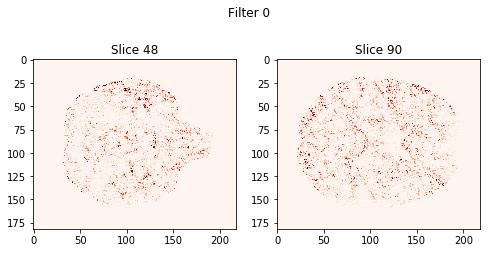

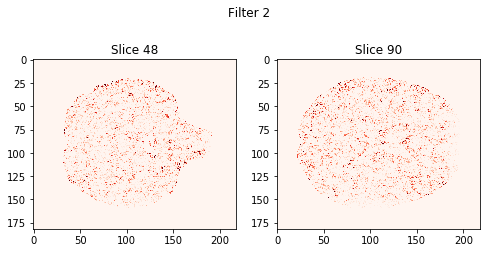

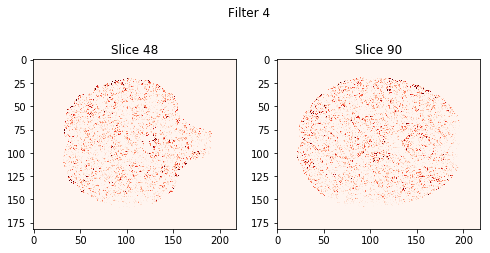

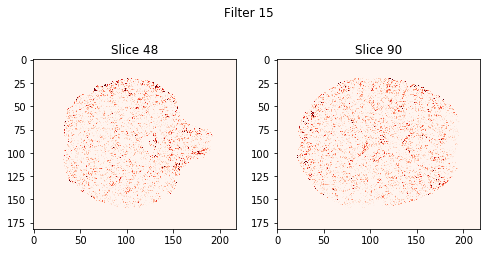

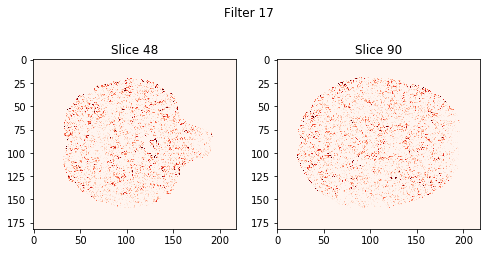

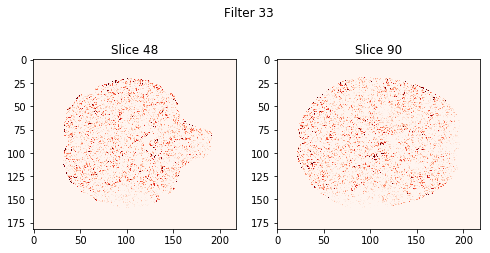

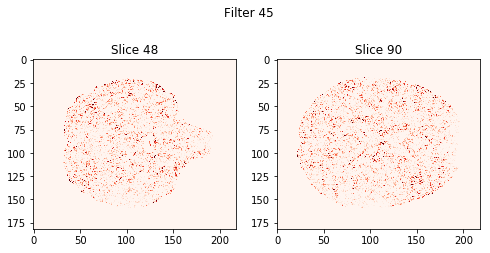

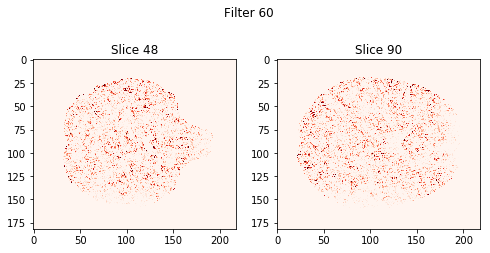

In [97]:
#for filter_pos in [4, 15, 33, 46, 47, 25, 60, 57, 58]:
#for filter_pos in [60, 57, 58]:
for filter_pos in[0, 2, 4, 15, 17, 33, 45, 60]:
    print("####### Next Filter #######")
    feature_map_shape = [15, 19, 15]
    img_idx = 0
    img = torch.unsqueeze(torch.unsqueeze(X[img_idx], 0), 0).cuda(gpu)
    LRP_maps = np.zeros(shape=X.shape[1:])
    for x in range(feature_map_shape[0]):
        for y in range(feature_map_shape[1]):
            for z in range(feature_map_shape[2]):
                print(x, y, z)
                AD_score, LRP_map = run_LRP(inn_model, 
                                            img,
                                            output_loc=np.index_exp[0, filter_pos, x, y, z])
                LRP_map = LRP_map.detach().cpu().numpy().squeeze()
                LRP_maps += LRP_map

    # visualize two slices
    fig, ax = plt.subplots(1, 2, figsize=(8, 4))
    vmin, vmax = np.percentile(LRP_maps, 90.0), np.percentile(LRP_maps, 99.9)
    ax[0].imshow(LRP_maps[:,:,48], cmap='Reds', vmin=vmin, vmax=vmax)
    ax[0].set_title("Slice 48")
    ax[1].imshow(LRP_maps[:,:,90], cmap='Reds', vmin=vmin, vmax=vmax)
    ax[1].set_title("Slice 90")
    fig.suptitle("Filter {}".format(filter_pos))
    fig.show()
    
    # save result on disk
    res_nifti = nib.Nifti1Image(LRP_maps, nifti.affine, header=nifti.header)
    nib.save(res_nifti, os.path.join(heatmap_dir, "LRP_latent-feature-map_visualization_Layer-{}_Filter-{}.nii.gz".format(lrp_layer, filter_pos)))

In [61]:
maps_sum = np.mean(LRP_maps, axis=0)

vmin, vmax = np.percentile(maps_sum, 90.0), np.percentile(maps_sum, 99.9)
#vmin, vmax = np.min(LRP_map), np.max(LRP_map)
plt.imshow(maps_sum[:,:,48], cmap='Reds', vmin=vmin, vmax=vmax)
plt.title("Filter {}".format(filter_pos))
plt.show()

vmin, vmax = np.percentile(maps_sum, 90.0), np.percentile(maps_sum, 99.9)
#vmin, vmax = np.min(LRP_map), np.max(LRP_map)
plt.imshow(maps_sum[:,:,90], cmap='Reds', vmin=vmin, vmax=vmax)
plt.title("Filter {}".format(filter_pos))
plt.show()

MemoryError: 

In [ ]:
def run_LRP(net, image_tensor):
    return inn_model.innvestigate(in_tensor=image_tensor, rel_for_class=273420)

In [ ]:
img_idx = 0
AD_score, LRP_map = run_LRP(inn_model, torch.unsqueeze(torch.unsqueeze(X[img_idx], 0), 0).cuda(gpu))
print(AD_score.shape)
AD_score = AD_score[0][0].detach().cpu().numpy()
LRP_map = LRP_map.detach().numpy().squeeze()

In [ ]:
vmin, vmax = np.percentile(LRP_map, 90.0), np.percentile(LRP_map, 99.9)
#vmin, vmax = np.min(LRP_map), np.max(LRP_map)
plt.imshow(LRP_map[:,:,90], cmap='Reds', vmin=vmin, vmax=vmax)
plt.show()

In [ ]:
vmin, vmax = np.percentile(LRP_map, 90.0), np.percentile(LRP_map, 99.9)
#vmin, vmax = np.min(LRP_map), np.max(LRP_map)
plt.imshow(LRP_map[:,:,90], cmap='Reds', vmin=vmin, vmax=vmax)
plt.show()

In [ ]:
vmin, vmax = np.percentile(LRP_map, 90.0), np.percentile(LRP_map, 99.9)
#vmin, vmax = np.min(LRP_map), np.max(LRP_map)
plt.imshow(LRP_map[:,:,90], cmap='Reds', vmin=vmin, vmax=vmax)
plt.show()

## Use conv 3 layer as output

In [93]:
class FlatNet(nn.Module):
    def __init__(self, drp_rate=0.3):
        super(FlatNet, self).__init__()
        self.drp_rate = drp_rate
        self.drop = nn.Dropout3d(p=self.drp_rate)
        self.Conv_1 = nn.Conv3d(1, 8, kernel_size=3, stride=1, padding=0)
        self.pool_1 = nn.MaxPool3d(kernel_size=3, stride=3, padding=0)
        self.Conv_2 = nn.Conv3d(8, 16, kernel_size=3, stride=1, padding=0)
        self.pool_2 = nn.MaxPool3d(kernel_size=3, stride=3, padding=0)
        self.Conv_3 = nn.Conv3d(16, 32, kernel_size=3, stride=1, padding=0)
        self.Conv_4 = nn.Conv3d(32, 64, kernel_size=3, stride=1, padding=0)
        #self.pool_4 = nn.MaxPool3d(kernel_size=4, stride=2, padding=0)
        #self.Conv_5 = nn.Conv3d(64, 64, kernel_size=3, stride=1, padding=0)
        #self.pool_5 = nn.MaxPool3d(kernel_size=4, stride=2, padding=0)


    def encode(self, x, print_size=False):
        if print_size:
            print(x.shape)
        x = F.elu(self.Conv_1(x))
        h = self.drop(self.pool_1(x))
        x = F.elu(self.Conv_2(h))
        if print_size:
            print(x.shape)
        h = self.drop(self.pool_2(x))
        x = F.elu(self.Conv_3(h))
        if print_size:
            print(x.shape)
        #h = self.drop(self.pool_4(x))
        return x

    def forward(self, x):
        print_size = False
        x = self.encode(x, print_size=print_size)
        #x = self.flatten(x)
        #x = self.classifier_scratch(x)
        return x
    
    def flatten(self, x):
        return x.view(x.size(0), -1)

In [94]:
# load pre-trained weights
flatnet = FlatNet()
#net.load_state_dict(torch.load(model_path))
#net = net.cuda(gpu)
#net.eval()

In [95]:
new_state_dict = flatnet.state_dict()
old_state_dict = net.state_dict()
# copy conv layers
print("Start with conv layers..")
for name, param in old_state_dict.items():
    if name in new_state_dict.keys():
        print(name)
        new_state_dict[name].copy_(param)
flatnet.load_state_dict(new_state_dict)

Start with conv layers..
Conv_1.weight
Conv_1.bias
Conv_2.weight
Conv_2.bias
Conv_3.weight
Conv_3.bias
Conv_4.weight
Conv_4.bias


In [96]:
# prepare model for LRP
flatnet.eval()
flatnet = torch.nn.Sequential(flatnet, torch.nn.Sigmoid())
inn_model = InnvestigateModel(flatnet, lrp_exponent=1,
                              method="b-rule",
                              beta=4, epsilon=1e-6).cuda(gpu)
inn_model.eval()

InnvestigateModel(
  (model): Sequential(
    (0): FlatNet(
      (drop): Dropout3d(p=0.3)
      (Conv_1): Conv3d(1, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1))
      (pool_1): MaxPool3d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
      (Conv_2): Conv3d(8, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1))
      (pool_2): MaxPool3d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
      (Conv_3): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1))
      (Conv_4): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    )
    (1): Sigmoid()
  )
)

In [97]:
def run_LRP(net, image_tensor, output_loc=np.index_exp[:, 63, 2, 4, 3]):
    #return inn_model.innvestigate(in_tensor=image_tensor, rel_for_class=10499)
    return inn_model.innvestigate(in_tensor=image_tensor, rel_for_class=output_loc)

In [ ]:
for filter_pos in [0, 4, 15]:
    print("####### Next Filter #######")
    feature_map_shape = [17, 21, 17]
    img_idx = 0
    img = torch.unsqueeze(torch.unsqueeze(X[img_idx], 0), 0).cuda(gpu)
    LRP_maps = []
    for x in range(feature_map_shape[0]):
        for y in range(feature_map_shape[1]):
            for z in range(feature_map_shape[2]):
                print(x, y, z)
                AD_score, LRP_map = run_LRP(inn_model, 
                                            img,
                                            output_loc=(0, filter_pos, x, y, z))
                LRP_map = LRP_map.detach().cpu().numpy().squeeze()
                LRP_maps.append(LRP_map)

    maps_sum = np.mean(LRP_maps, axis=0)

    vmin, vmax = np.percentile(maps_sum, 90.0), np.percentile(maps_sum, 99.9)
    #vmin, vmax = np.min(LRP_map), np.max(LRP_map)
    plt.imshow(maps_sum[:,:,48], cmap='Reds', vmin=vmin, vmax=vmax)
    plt.title("Filter {}".format(filter_pos))
    plt.show()

    vmin, vmax = np.percentile(maps_sum, 90.0), np.percentile(maps_sum, 99.9)
    #vmin, vmax = np.min(LRP_map), np.max(LRP_map)
    plt.imshow(maps_sum[:,:,90], cmap='Reds', vmin=vmin, vmax=vmax)
    plt.title("Filter {}".format(filter_pos))
    plt.show()

####### Next Filter #######
0 0 0
0 0 1
0 0 2
0 0 3
0 0 4
0 0 5
0 0 6
0 0 7
0 0 8
0 0 9
0 0 10
0 0 11
0 0 12
0 0 13
0 0 14
0 0 15
0 0 16
0 1 0
0 1 1
0 1 2
0 1 3
0 1 4
0 1 5
0 1 6
0 1 7
0 1 8
0 1 9
0 1 10
0 1 11
0 1 12
0 1 13
0 1 14
0 1 15
0 1 16
0 2 0
0 2 1
0 2 2
0 2 3
0 2 4
0 2 5
0 2 6
0 2 7
0 2 8
0 2 9
0 2 10
0 2 11
0 2 12
0 2 13
0 2 14
0 2 15
0 2 16
0 3 0
0 3 1
0 3 2
0 3 3
0 3 4
0 3 5
0 3 6
0 3 7
0 3 8
0 3 9
0 3 10
0 3 11
0 3 12
0 3 13
0 3 14
0 3 15
0 3 16
0 4 0
0 4 1
0 4 2
0 4 3
0 4 4
0 4 5
0 4 6
0 4 7
0 4 8
0 4 9
0 4 10
0 4 11
0 4 12
0 4 13
0 4 14
0 4 15
0 4 16
0 5 0
0 5 1
0 5 2
0 5 3
0 5 4
0 5 5
0 5 6
0 5 7
0 5 8
0 5 9
0 5 10
0 5 11
0 5 12
0 5 13
0 5 14
0 5 15
0 5 16
0 6 0
0 6 1
0 6 2
0 6 3
0 6 4
0 6 5
0 6 6
0 6 7
0 6 8
0 6 9
0 6 10
0 6 11
0 6 12
0 6 13
0 6 14
0 6 15
0 6 16
0 7 0
0 7 1
0 7 2
0 7 3
0 7 4
0 7 5
0 7 6
0 7 7
0 7 8
0 7 9
0 7 10
0 7 11
0 7 12
0 7 13
0 7 14
0 7 15
0 7 16
0 8 0
0 8 1
0 8 2
0 8 3
0 8 4
0 8 5
0 8 6
0 8 7
0 8 8
0 8 9
0 8 10
0 8 11
0 8 12
0 8 13
0 8 14
0 8 1

3 14 5
3 14 6
3 14 7
3 14 8
3 14 9
3 14 10
3 14 11
3 14 12
3 14 13
3 14 14
3 14 15
3 14 16
3 15 0
3 15 1
3 15 2
3 15 3
3 15 4
3 15 5
3 15 6
3 15 7
3 15 8
3 15 9
3 15 10
3 15 11
3 15 12
3 15 13
3 15 14
3 15 15
3 15 16
3 16 0
3 16 1
3 16 2
3 16 3
3 16 4
3 16 5
3 16 6
3 16 7
3 16 8
3 16 9
3 16 10
3 16 11
3 16 12
3 16 13
3 16 14
3 16 15
3 16 16
3 17 0
3 17 1
3 17 2
3 17 3
3 17 4
3 17 5
3 17 6
3 17 7
3 17 8
3 17 9
3 17 10
3 17 11
3 17 12
3 17 13
3 17 14
3 17 15
3 17 16
3 18 0
3 18 1
3 18 2
3 18 3
3 18 4
3 18 5
3 18 6
3 18 7
3 18 8
3 18 9
3 18 10
3 18 11
3 18 12
3 18 13
3 18 14
3 18 15
3 18 16
3 19 0
3 19 1
3 19 2
3 19 3
3 19 4
3 19 5
3 19 6
3 19 7
3 19 8
3 19 9
3 19 10
3 19 11
3 19 12
3 19 13
3 19 14
3 19 15
3 19 16
3 20 0
3 20 1
3 20 2
3 20 3
3 20 4
3 20 5
3 20 6
3 20 7
3 20 8
3 20 9
3 20 10
3 20 11
3 20 12
3 20 13
3 20 14
3 20 15
3 20 16
4 0 0
4 0 1
4 0 2
4 0 3
4 0 4
4 0 5
4 0 6
4 0 7
4 0 8
4 0 9
4 0 10
4 0 11
4 0 12
4 0 13
4 0 14
4 0 15
4 0 16
4 1 0
4 1 1
4 1 2
4 1 3
4 1 4
4 1 5
4 1 6
4 

6 20 7
6 20 8
6 20 9
6 20 10
6 20 11
6 20 12
6 20 13
6 20 14
6 20 15
6 20 16
7 0 0
7 0 1
7 0 2
7 0 3
7 0 4
7 0 5
7 0 6
7 0 7
7 0 8
7 0 9
7 0 10
7 0 11
7 0 12
7 0 13
7 0 14
7 0 15
7 0 16
7 1 0
7 1 1
7 1 2
7 1 3
7 1 4
7 1 5
7 1 6
7 1 7
7 1 8
7 1 9
7 1 10
7 1 11
7 1 12
7 1 13
7 1 14
7 1 15
7 1 16
7 2 0
7 2 1
7 2 2
7 2 3
7 2 4
7 2 5
7 2 6
7 2 7
7 2 8
7 2 9
7 2 10
7 2 11
7 2 12
7 2 13
7 2 14
7 2 15
7 2 16
7 3 0
7 3 1
7 3 2
7 3 3
7 3 4
7 3 5
7 3 6
7 3 7
7 3 8
7 3 9
7 3 10
7 3 11
7 3 12
7 3 13
7 3 14
7 3 15
7 3 16
7 4 0
7 4 1
7 4 2
7 4 3
7 4 4
7 4 5
7 4 6
7 4 7
7 4 8
7 4 9
7 4 10
7 4 11
7 4 12
7 4 13
7 4 14
7 4 15
7 4 16
7 5 0
7 5 1
7 5 2
7 5 3
7 5 4
7 5 5
7 5 6
7 5 7
7 5 8
7 5 9
7 5 10
7 5 11
7 5 12
7 5 13
7 5 14
7 5 15
7 5 16
7 6 0
7 6 1
7 6 2
7 6 3
7 6 4
7 6 5
7 6 6
7 6 7
7 6 8
7 6 9
7 6 10
7 6 11
7 6 12
7 6 13
7 6 14
7 6 15
7 6 16
7 7 0
7 7 1
7 7 2
7 7 3
7 7 4
7 7 5
7 7 6
7 7 7
7 7 8
7 7 9
7 7 10
7 7 11
7 7 12
7 7 13
7 7 14
7 7 15
7 7 16
7 8 0
7 8 1
7 8 2
7 8 3
7 8 4
7 8 5
7 8 6
7 8 7
7 8

10 5 9
10 5 10
10 5 11
10 5 12
10 5 13
10 5 14
10 5 15
10 5 16
10 6 0
10 6 1
10 6 2
10 6 3
10 6 4
10 6 5
10 6 6
10 6 7
10 6 8
10 6 9
10 6 10
10 6 11
10 6 12
10 6 13
10 6 14
10 6 15
10 6 16
10 7 0
10 7 1
10 7 2
10 7 3
10 7 4
10 7 5
10 7 6
10 7 7
10 7 8
10 7 9
10 7 10
10 7 11
10 7 12
10 7 13
10 7 14
10 7 15
10 7 16
10 8 0
10 8 1
10 8 2
10 8 3
10 8 4
10 8 5
10 8 6
10 8 7
10 8 8
10 8 9
10 8 10
10 8 11
10 8 12
10 8 13
10 8 14
10 8 15
10 8 16
10 9 0
10 9 1
10 9 2
10 9 3
10 9 4
10 9 5
10 9 6
10 9 7
10 9 8
10 9 9
10 9 10
10 9 11
10 9 12
10 9 13
10 9 14
10 9 15
10 9 16
10 10 0
10 10 1
10 10 2
10 10 3
10 10 4
10 10 5
10 10 6
10 10 7
10 10 8
10 10 9
10 10 10
10 10 11
10 10 12
10 10 13
10 10 14
10 10 15
10 10 16
10 11 0
10 11 1
10 11 2
10 11 3
10 11 4
10 11 5
10 11 6
10 11 7
10 11 8
10 11 9
10 11 10
10 11 11
10 11 12
10 11 13
10 11 14
10 11 15
10 11 16
10 12 0
10 12 1
10 12 2
10 12 3
10 12 4
10 12 5
10 12 6
10 12 7
10 12 8
10 12 9
10 12 10
10 12 11
10 12 12
10 12 13
10 12 14
10 12 15
10 12 16
10 1

13 3 2
13 3 3
13 3 4
13 3 5
13 3 6
13 3 7
13 3 8
13 3 9
13 3 10
13 3 11
13 3 12
13 3 13
13 3 14
13 3 15
13 3 16
13 4 0
13 4 1
13 4 2
13 4 3
13 4 4
13 4 5
13 4 6
13 4 7
13 4 8
13 4 9
13 4 10
13 4 11
13 4 12
13 4 13
13 4 14
13 4 15
13 4 16
13 5 0
13 5 1
13 5 2
13 5 3
13 5 4
13 5 5
13 5 6
13 5 7
13 5 8
13 5 9
13 5 10
13 5 11
13 5 12
13 5 13
13 5 14
13 5 15
13 5 16
13 6 0
13 6 1
13 6 2
13 6 3
13 6 4
13 6 5
13 6 6
13 6 7
13 6 8
13 6 9
13 6 10
13 6 11
13 6 12
13 6 13
13 6 14
13 6 15
13 6 16
13 7 0
13 7 1
13 7 2
13 7 3
13 7 4
13 7 5
13 7 6
13 7 7
13 7 8
13 7 9
13 7 10
13 7 11
13 7 12
13 7 13
13 7 14
13 7 15
13 7 16
13 8 0
13 8 1
13 8 2
13 8 3
13 8 4
13 8 5
13 8 6
13 8 7
13 8 8
13 8 9
13 8 10
13 8 11
13 8 12
13 8 13
13 8 14
13 8 15
13 8 16
13 9 0
13 9 1
13 9 2
13 9 3
13 9 4
13 9 5
13 9 6
13 9 7
13 9 8
13 9 9
13 9 10
13 9 11
13 9 12
13 9 13
13 9 14
13 9 15
13 9 16
13 10 0
13 10 1
13 10 2
13 10 3
13 10 4
13 10 5
13 10 6
13 10 7
13 10 8
13 10 9
13 10 10
13 10 11
13 10 12
13 10 13
13 10 14
13 10 1

In [ ]:
img_idx = 0
AD_score, LRP_map = run_LRP(inn_model, torch.unsqueeze(torch.unsqueeze(X[img_idx], 0), 0).cuda(gpu))
print(AD_score.shape)
AD_score = AD_score[0][0].detach().cpu().numpy()
LRP_map = LRP_map.detach().numpy().squeeze()

In [ ]:
vmin, vmax = np.percentile(LRP_map, 90.0), np.percentile(LRP_map, 99.9)
#vmin, vmax = np.min(LRP_map), np.max(LRP_map)
plt.imshow(LRP_map[:,:,90], cmap='Reds', vmin=vmin, vmax=vmax)
plt.show()

In [1]:
vmin, vmax = np.percentile(LRP_map, 90.0), np.percentile(LRP_map, 99.9)
#vmin, vmax = np.min(LRP_map), np.max(LRP_map)
plt.imshow(LRP_map[:,:,90], cmap='Reds', vmin=vmin, vmax=vmax)
plt.show()

NameError: name 'np' is not defined

## Use conv 2 layer as output

In [ ]:
class FlatNet(nn.Module):
    def __init__(self, drp_rate=0.3):
        super(FlatNet, self).__init__()
        self.drp_rate = drp_rate
        self.drop = nn.Dropout3d(p=self.drp_rate)
        self.Conv_1 = nn.Conv3d(1, 8, kernel_size=3, stride=1, padding=0)
        self.pool_1 = nn.MaxPool3d(kernel_size=3, stride=3, padding=0)
        self.Conv_2 = nn.Conv3d(8, 16, kernel_size=3, stride=1, padding=0)
        self.pool_2 = nn.MaxPool3d(kernel_size=3, stride=3, padding=0)
        #self.pool_4 = nn.MaxPool3d(kernel_size=4, stride=2, padding=0)
        #self.Conv_5 = nn.Conv3d(64, 64, kernel_size=3, stride=1, padding=0)
        #self.pool_5 = nn.MaxPool3d(kernel_size=4, stride=2, padding=0)


    def encode(self, x, print_size=False):
        if print_size:
            print(x.shape)
        x = F.elu(self.Conv_1(x))
        h = self.drop(self.pool_1(x))
        x = F.elu(self.Conv_2(h))
        if print_size:
            print(x.shape)
        h = self.drop(self.pool_2(x))
        #h = self.drop(self.pool_4(x))
        return h

    def forward(self, x):
        print_size = True
        x = self.encode(x, print_size=print_size)
        x = self.flatten(x)
        #x = self.classifier_scratch(x)
        return x
    
    def flatten(self, x):
        return x.view(x.size(0), -1)

In [ ]:
# load pre-trained weights
flatnet = FlatNet()
#net.load_state_dict(torch.load(model_path))
#net = net.cuda(gpu)
#net.eval()

In [ ]:
new_state_dict = flatnet.state_dict()
old_state_dict = net.state_dict()
# copy conv layers
print("Start with conv layers..")
for name, param in old_state_dict.items():
    if name in new_state_dict.keys():
        print(name)
        new_state_dict[name].copy_(param)
flatnet.load_state_dict(new_state_dict)

In [ ]:
# prepare model for LRP
flatnet.eval()
flatnet = torch.nn.Sequential(flatnet, torch.nn.Sigmoid())
inn_model = InnvestigateModel(flatnet, lrp_exponent=1,
                              method="b-rule",
                              beta=4, epsilon=1e-6).cuda(gpu)
inn_model.eval()

In [ ]:
for class_idx in np.random.randint(0, 132848, size=30):
    print("Neuron {}".format(class_idx))
    def run_LRP(net, image_tensor):
        return inn_model.innvestigate(in_tensor=image_tensor, rel_for_class=class_idx)

    img_idx = 0
    AD_score, LRP_map = run_LRP(inn_model, torch.unsqueeze(torch.unsqueeze(X[img_idx], 0), 0).cuda(gpu))
    print(AD_score.shape)
    AD_score = AD_score[0][0].detach().cpu().numpy()
    LRP_map = LRP_map.detach().numpy().squeeze()

    vmin, vmax = np.percentile(LRP_map, 90.0), np.percentile(LRP_map, 99.9999)
    #vmin, vmax = np.min(LRP_map), np.max(LRP_map)
    max_slice = np.argmax(np.sum(LRP_map, axis=(0,1)))
    print("Maximized slice {}".format(max_slice))
    plt.imshow(LRP_map[:,:,max_slice], cmap='Reds')#, vmin=vmin, vmax=vmax)
    plt.show()

In [ ]:
vmin, vmax = np.percentile(LRP_map, 90.0), np.percentile(LRP_map, 99.9999)
#vmin, vmax = np.min(LRP_map), np.max(LRP_map)
max_slice = np.argmax(np.sum(LRP_map, axis=(0,1)))
print("Maximized slice {}".format(max_slice))
plt.imshow(LRP_map[:,:,max_slice], cmap='Reds', vmin=vmin, vmax=vmax)
plt.show()

In [ ]:
5/0

In [ ]:
vmin, vmax = np.percentile(LRP_map, 90.0), np.percentile(LRP_map, 99.9)
plt.imshow(LRP_map[:,:,90], cmap='Reds', vmin=vmin, vmax=vmax)
plt.show()

# Backpropagate from feature map

In [ ]:
std = torch.Tensor([0.05, 0.05, 0.05, 0.05]).repeat(4,4,1).unsqueeze(0)
gaussian_kernel = torch.normal(mean=1, std=std).unsqueeze(0)

In [ ]:
gaussian_kernel.shape

In [ ]:
# Create a model up to the feature map intended for investigation
class SubModel(nn.Module):
    def __init__(self, drp_rate=0.3, blur_kernel=None):
        super(SubModel, self).__init__()
        self.drp_rate = drp_rate
        self.drop = nn.Dropout3d(p=self.drp_rate)
        self.Conv_1 = nn.Conv3d(1, 64, kernel_size=3, stride=1, padding=0)
        self.pool_1 = nn.MaxPool3d(kernel_size=3, stride=3, padding=0)
        self.Conv_2 = nn.Conv3d(64, 64, kernel_size=3, stride=1, padding=0)
        self.pool_2 = nn.MaxPool3d(kernel_size=3, stride=2, padding=0)
        self.Conv_3 = nn.Conv3d(64, 64, kernel_size=3, stride=1, padding=0)
        self.Conv_4 = nn.Conv3d(64, 64, kernel_size=3, stride=1, padding=0)
        self.pool_4 = nn.MaxPool3d(kernel_size=3, stride=3, padding=0)
        
        self.blur = blur_kernel
        
    def encode(self, x, print_size=False):
        if print_size:
            print(x.shape)
        x = F.elu(self.Conv_1(x))
        h = self.drop(self.pool_1(x))
        x = F.elu(self.Conv_2(h))
        if print_size:
            print(x.shape)
        h = self.drop(self.pool_2(x))
        x = F.elu(self.Conv_3(h))
        if print_size:
            print(x.shape)
        x = F.elu(self.Conv_4(x))
        #x = self.Conv_4(x) # remove activation to match original feature map
        if print_size:
            print(x.shape)
        return x

    def forward(self, x):
        print_size = False
        if self.blur is not None:
            x = F.conv3d(x, weight=self.blur.cuda(gpu), stride=1)
        x = self.encode(x, print_size=print_size)
        return x
    
    def flatten(self, x):
        return x.view(x.size(0), -1)

In [ ]:
sub_model = SubModel(blur_kernel=gaussian_kernel)

In [ ]:
new_state_dict = sub_model.state_dict()
old_state_dict = net.state_dict()
for name, param in old_state_dict.items():
    if name in new_state_dict.keys():
        print(name)
        new_state_dict[name].copy_(param)

sub_model.load_state_dict(new_state_dict)


In [ ]:
sub_model.load_state_dict(new_state_dict)

In [ ]:
sub_model.cuda(gpu)
sub_model.eval()

In [ ]:
X = X.requires_grad_()

In [ ]:
sub_model.zero_grad()

In [ ]:
res = sub_model.forward(torch.unsqueeze(X, 1).cuda(gpu))

In [ ]:
plt.imshow(saver.get_activation()[5].cpu().numpy()[:,:,5])
plt.show()

In [ ]:
res_img = res[1].cpu().detach().numpy()

In [ ]:
for filter_pos in range(5):
    plt.imshow(res_img[filter_pos][:,:,5])
    plt.show()

In [ ]:
res.shape

In [ ]:
image_pos = 1
filter_pos = 20

In [ ]:
grad = torch.mean(torch.abs(res[image_pos, filter_pos]))

In [ ]:
grad.backward()

In [ ]:
print(torch.sum(X.grad))

In [ ]:
print(torch.sum(X.grad))

In [ ]:
#for i in range(5):
plt.imshow(X.grad.cpu().numpy()[1,:,:,48], cmap='gray')
plt.show()

In [ ]:
#for i in range(5):
plt.imshow(X.grad.cpu().numpy()[1,:,:,48], cmap='gray')
plt.show()

In [ ]:
#for i in range(5):
plt.imshow(X.grad.cpu().numpy()[1,:,:,48], cmap='gray')
plt.show()

### Optimization loop

In [ ]:
base = torch.rand((1, 1, 96, 114, 96), requires_grad=True)
plt.imshow(base.cpu().detach().numpy()[0,0,:,:,48],cmap='gray')
plt.show()

smoothed = F.conv3d(base, weight=gaussian_kernel, stride=1)
plt.imshow(smoothed.cpu().detach().numpy()[0,0,:,:,48],cmap='gray')
plt.show()

In [ ]:
num_iters = 2000
base = torch.rand((1, 1, 96, 114, 96), requires_grad=True)
optimizer = optim.Adam([base], lr=0.05, weight_decay=0.01)
l1_loss = nn.L1Loss(reduction='mean')
loss = 0

for i in range(num_iters + 1):
    if i % 200 == 0:
        print("Iteration {}. Loss {}".format(i, loss))
        plt.imshow(base.cpu().detach().numpy()[0,0,:,:,48],cmap='gray')
        plt.show()
    #base = F.conv3d(base, weight=gaussian_kernel, stride=1)
    sub_model.zero_grad()
    
    res = sub_model.forward(base.cuda(gpu))
    l1 = l1_loss(res[0, filter_pos], torch.zeros_like(res[0, filter_pos]))
    #print(l1)
    loss = -torch.sum(torch.abs(res[0, filter_pos])) + l1 * 100
    #print(loss)
    loss.backward()
    optimizer.step()

plt.imshow(base.cpu().detach().numpy()[0,0,:,:,48],cmap='gray')
plt.show()

In [ ]:
filter_pos = 10

In [ ]:
num_iters = 2000
base = torch.rand((1, 1, 96, 114, 96), requires_grad=True)
optimizer = optim.Adam([base], lr=0.05, weight_decay=0.01)
l1_loss = nn.L1Loss(reduction='mean')
loss = 0

for i in range(num_iters + 1):
    if i % 200 == 0:
        print("Iteration {}. Loss {}".format(i, loss))
        plt.imshow(base.cpu().detach().numpy()[0,0,:,:,48],cmap='gray')
        plt.show()
    #base = F.conv3d(base, weight=gaussian_kernel, stride=1)
    sub_model.zero_grad()
    
    res = sub_model.forward(base.cuda(gpu))
    l1 = l1_loss(res[0, filter_pos], torch.zeros_like(res[0, filter_pos]))
    #print(l1)
    loss = -torch.sum(torch.abs(res[0, filter_pos])) + l1 * 100
    #print(loss)
    loss.backward()
    optimizer.step()

plt.imshow(base.cpu().detach().numpy()[0,0,:,:,48],cmap='gray')
plt.show()

In [ ]:
filter_pos = 43

In [ ]:
num_iters = 2000
base = torch.rand((1, 1, 96, 114, 96), requires_grad=True)
optimizer = optim.Adam([base], lr=0.05, weight_decay=0.01)
l1_loss = nn.L1Loss(reduction='mean')
loss = 0

for i in range(num_iters + 1):
    if i % 200 == 0:
        print("Iteration {}. Loss {}".format(i, loss))
        plt.imshow(base.cpu().detach().numpy()[0,0,:,:,48],cmap='gray')
        plt.show()
    #base = F.conv3d(base, weight=gaussian_kernel, stride=1)
    sub_model.zero_grad()
    
    res = sub_model.forward(base.cuda(gpu))
    l1 = l1_loss(res[0, filter_pos], torch.zeros_like(res[0, filter_pos]))
    #print(l1)
    loss = -torch.sum(torch.abs(res[0, filter_pos])) + l1 * 10
    #print(loss)
    loss.backward()
    optimizer.step()

plt.imshow(base.cpu().detach().numpy()[0,0,:,:,48],cmap='gray')
plt.show()

In [ ]:
filter_pos = 43

In [ ]:
num_iters = 2000
base = torch.rand((1, 1, 96, 114, 96), requires_grad=True)
optimizer = optim.Adam([base], lr=0.05, weight_decay=0.01)
l1_loss = nn.L1Loss(reduction='mean')
loss = 0

for i in range(num_iters + 1):
    if i % 200 == 0:
        print("Iteration {}. Loss {}".format(i, loss))
        plt.imshow(base.cpu().detach().numpy()[0,0,:,:,48],cmap='gray')
        plt.show()
    #base = F.conv3d(base, weight=gaussian_kernel, stride=1)
    sub_model.zero_grad()
    
    res = sub_model.forward(base.cuda(gpu))
    l1 = l1_loss(res[0, filter_pos], torch.zeros_like(res[0, filter_pos]))
    #print(l1)
    loss = -torch.sum(torch.abs(res[0, filter_pos])) + l1 * 10
    #print(loss)
    loss.backward()
    optimizer.step()

plt.imshow(base.cpu().detach().numpy()[0,0,:,:,48],cmap='gray')
plt.show()

In [ ]:
res = sub_model.forward(base.cuda(gpu))

In [ ]:
torch.sum(torch.abs(res[0, filter_pos]))

In [ ]:
torch.sum(torch.abs(res[0, filter_pos-14]))

In [ ]:
res = sub_model.forward(torch.unsqueeze(X[[0]], 1).cuda(gpu))

In [ ]:
torch.sum(torch.abs(res[0, filter_pos]))

In [ ]:
torch.sum(torch.abs(res[0, filter_pos-14]))

In [ ]:
plt.imshow(base.cpu().detach().numpy()[0,0,:,:,48],cmap='gray')
plt.show()

## Using PIF Layer as output

In [ ]:
# Create a model up to the feature map intended for investigation
class SubModel(nn.Module):
    def __init__(self, drp_rate=0.3, blur_kernel=None):
        super(SubModel, self).__init__()
        self.blur = blur_kernel
        
        self.drp_rate = drp_rate
        self.drop = nn.Dropout3d(p=self.drp_rate)
        self.Conv_1 = nn.Conv3d(1, 64, kernel_size=3, stride=1, padding=0)
        self.pool_1 = nn.MaxPool3d(kernel_size=3, stride=3, padding=0)
        self.Conv_2 = nn.Conv3d(64, 64, kernel_size=3, stride=1, padding=0)
        self.pool_2 = nn.MaxPool3d(kernel_size=3, stride=2, padding=0)
        self.Conv_3 = nn.Conv3d(64, 64, kernel_size=3, stride=1, padding=0)
        self.Conv_4 = nn.Conv3d(64, 64, kernel_size=3, stride=1, padding=0)
        self.pool_4 = nn.MaxPool3d(kernel_size=3, stride=3, padding=0)
        
        self.pif = PatchIndividualFilters3D([10,13,10],
                                    filter_shape=(3,3,3),
                                    patch_shape=(5,5,5),
                                    num_local_filter_in=64,
                                    num_local_filter_out=3,
                                    overlap=1,
                                    reassemble=False,
                                    debug=False)
        

        
    def encode(self, x, print_size=False):
        if print_size:
            print(x.shape)
        x = F.elu(self.Conv_1(x))
        h = self.drop(self.pool_1(x))
        x = F.elu(self.Conv_2(h))
        if print_size:
            print(x.shape)
        h = self.drop(self.pool_2(x))
        x = F.elu(self.Conv_3(h))
        if print_size:
            print(x.shape)
        x = F.elu(self.Conv_4(x))
        #x = self.Conv_4(x) # remove activation to match original feature map
        if print_size:
            print(x.shape)
        return x

    def forward(self, x):
        print_size = False
        if self.blur is not None:
            x = F.conv3d(x, weight=self.blur.cuda(gpu), stride=1, padding=1)
        x = self.encode(x, print_size=print_size)
        x = F.elu(self.pif(x))
        return x
    
    def flatten(self, x):
        return x.view(x.size(0), -1)

In [ ]:
sub_model = SubModel(blur_kernel=gaussian_kernel)

new_state_dict = sub_model.state_dict()
old_state_dict = net.state_dict()
for name, param in old_state_dict.items():
    if name in new_state_dict.keys():
        print(name)
        new_state_dict[name].copy_(param)

sub_model.load_state_dict(new_state_dict)

sub_model.cuda(gpu)
sub_model.eval()

In [ ]:
filter_pos = 1

In [ ]:
num_iters = 2000
base = torch.rand((1, 1, 96, 114, 96), requires_grad=True)
optimizer = optim.Adam([base], lr=0.05, weight_decay=0.01)
l1_loss = nn.L1Loss(reduction='mean')
loss = 0

for i in range(num_iters + 1):
    if i % 200 == 0:
        print("Iteration {}. Loss {}".format(i, loss))
        plt.imshow(base.cpu().detach().numpy()[0,0,:,:,48],cmap='gray')
        plt.show()
    #base = F.conv3d(base, weight=gaussian_kernel, stride=1)
    sub_model.zero_grad()
    
    res = sub_model.forward(base.cuda(gpu))
    l1 = l1_loss(res[0, filter_pos], torch.zeros_like(res[0, filter_pos]))
    #print(l1)
    loss = -torch.sum(torch.abs(res[0, filter_pos])) + l1 * 10
    #print(loss)
    loss.backward()
    optimizer.step()

plt.imshow(base.cpu().detach().numpy()[0,0,:,:,48],cmap='gray')
plt.show()

In [ ]:
filter_pos = 2

In [ ]:
num_iters = 2000
base = torch.rand((1, 1, 96, 114, 96), requires_grad=True)
optimizer = optim.Adam([base], lr=0.05, weight_decay=0.01)
l1_loss = nn.L1Loss(reduction='mean')
loss = 0

for i in range(num_iters + 1):
    if i % 200 == 0:
        print("Iteration {}. Loss {}".format(i, loss))
        plt.imshow(base.cpu().detach().numpy()[0,0,:,:,48],cmap='gray')
        plt.show()
    #base = F.conv3d(base, weight=gaussian_kernel, stride=1)
    sub_model.zero_grad()
    
    res = sub_model.forward(base.cuda(gpu))
    l1 = l1_loss(res[0, filter_pos], torch.zeros_like(res[0, filter_pos]))
    #print(l1)
    loss = -torch.sum(torch.abs(res[0, filter_pos])) + l1 * 10
    #print(loss)
    loss.backward()
    optimizer.step()

plt.imshow(base.cpu().detach().numpy()[0,0,:,:,48],cmap='gray')
plt.show()

## Early layers

In [ ]:
# Create a model up to the feature map intended for investigation
class SubModel(nn.Module):
    def __init__(self, drp_rate=0.3, blur_kernel=None):
        super(SubModel, self).__init__()
        self.blur = blur_kernel
        
        self.drp_rate = drp_rate
        self.drop = nn.Dropout3d(p=self.drp_rate)
        self.Conv_1 = nn.Conv3d(1, 64, kernel_size=3, stride=1, padding=0)
        self.pool_1 = nn.MaxPool3d(kernel_size=3, stride=3, padding=0)
        self.Conv_2 = nn.Conv3d(64, 64, kernel_size=3, stride=1, padding=0)

        
    def encode(self, x, print_size=False):
        if print_size:
            print(x.shape)
        x = F.elu(self.Conv_1(x))
        h = self.drop(self.pool_1(x))
        x = F.elu(self.Conv_2(h))
        return x

    def forward(self, x):
        print_size = False
        if self.blur is not None:
            x = F.conv3d(x, weight=self.blur.cuda(gpu), stride=1, padding=1)
        x = self.encode(x, print_size=print_size)
        return x
    
    def flatten(self, x):
        return x.view(x.size(0), -1)

In [ ]:
sub_model = SubModel(blur_kernel=gaussian_kernel)

new_state_dict = sub_model.state_dict()
old_state_dict = net.state_dict()
for name, param in old_state_dict.items():
    if name in new_state_dict.keys():
        print(name)
        new_state_dict[name].copy_(param)

sub_model.load_state_dict(new_state_dict)

sub_model.cuda(gpu)
sub_model.eval()

In [ ]:
def optimize_activations(sub_model, base, optimizer, filter_pos=0, num_iters=2000, show_x=200):
    loss = 0
    l1_loss = nn.L1Loss(reduction='mean')
    
    for i in range(num_iters + 1):
        if i % show_x == 0:
            print("Iteration {}. Loss {}".format(i, loss))
            plt.imshow(base.cpu().detach().numpy()[0,0,:,:,48],cmap='gray')
            plt.show()
        #base = F.conv3d(base, weight=gaussian_kernel, stride=1)
        sub_model.zero_grad()

        res = sub_model.forward(base.cuda(gpu))
        l1 = l1_loss(res[0, filter_pos], torch.zeros_like(res[0, filter_pos]))
        #print(l1)
        loss = -torch.sum(torch.abs(res[0, filter_pos])) + l1 * 10
        #print(loss)
        loss.backward()
        optimizer.step()
    print("Final output:")
    plt.imshow(base.cpu().detach().numpy()[0,0,:,:,48],cmap='gray')
    plt.show()

In [ ]:
filter_pos = 1
print("Filter position: {}".format(filter_pos)) 
num_iters = 2000
base = torch.rand((1, 1, 96, 114, 96), requires_grad=True) # input image
optimizer = optim.Adam([base], lr=0.05, weight_decay=0.01)

optimize_activations(sub_model, base, optimizer, filter_pos=filter_pos, num_iters=num_iters, show_x=num_iters+1)

In [ ]:
for filter_pos in [13, 14, 15, 26, 27, 28, 39, 40, 41, 61, 62, 63]:
    print("Filter position: {}".format(filter_pos)) 
    num_iters = 2000
    base = torch.rand((1, 1, 96, 114, 96), requires_grad=True) # input image
    optimizer = optim.Adam([base], lr=0.05, weight_decay=0.01)

    optimize_activations(sub_model, base, optimizer, filter_pos=filter_pos, num_iters=num_iters, show_x=num_iters+1)

In [ ]:
# Create a model up to the feature map intended for investigation
class SubModel(nn.Module):
    def __init__(self, drp_rate=0.3, blur_kernel=None):
        super(SubModel, self).__init__()
        self.blur = blur_kernel
        
        self.drp_rate = drp_rate
        self.drop = nn.Dropout3d(p=self.drp_rate)
        self.Conv_1 = nn.Conv3d(1, 64, kernel_size=3, stride=1, padding=0)

        
    def encode(self, x, print_size=False):
        if print_size:
            print(x.shape)
        x = F.elu(self.Conv_1(x))
        return x

    def forward(self, x):
        print_size = False
        if self.blur is not None:
            x = F.conv3d(x, weight=self.blur.cuda(gpu), stride=1, padding=1)
        x = self.encode(x, print_size=print_size)
        return x
    
    def flatten(self, x):
        return x.view(x.size(0), -1)

In [ ]:
sub_model = SubModel(blur_kernel=gaussian_kernel)

new_state_dict = sub_model.state_dict()
old_state_dict = net.state_dict()
for name, param in old_state_dict.items():
    if name in new_state_dict.keys():
        print(name)
        new_state_dict[name].copy_(param)

sub_model.load_state_dict(new_state_dict)

sub_model.cuda(gpu)
sub_model.eval()

In [ ]:
for filter_pos in [13, 14, 15, 26, 27, 28, 39, 40, 41, 61, 62, 63]:
    print("Filter position: {}".format(filter_pos)) 
    num_iters = 2000
    base = torch.rand((1, 1, 96, 114, 96), requires_grad=True) # input image
    optimizer = optim.Adam([base], lr=0.05, weight_decay=0.01)

    optimize_activations(sub_model, base, optimizer, filter_pos=filter_pos, num_iters=num_iters, show_x=num_iters+1)

## Add transformation robustness

In [ ]:
# Create a model up to the feature map intended for investigation
class SubModel(nn.Module):
    def __init__(self, drp_rate=0.3, blur_kernel=None):
        super(SubModel, self).__init__()
        self.blur = blur_kernel
        
        self.drp_rate = drp_rate
        self.drop = nn.Dropout3d(p=self.drp_rate)
        self.Conv_1 = nn.Conv3d(1, 64, kernel_size=3, stride=1, padding=0)
        self.pool_1 = nn.MaxPool3d(kernel_size=3, stride=3, padding=0)
        self.Conv_2 = nn.Conv3d(64, 64, kernel_size=3, stride=1, padding=0)
        self.pool_2 = nn.MaxPool3d(kernel_size=3, stride=2, padding=0)
        self.Conv_3 = nn.Conv3d(64, 64, kernel_size=3, stride=1, padding=0)
        self.Conv_4 = nn.Conv3d(64, 64, kernel_size=3, stride=1, padding=0)
        self.pool_4 = nn.MaxPool3d(kernel_size=3, stride=3, padding=0)
        
        self.pif = PatchIndividualFilters3D([10,13,10],
                                    filter_shape=(3,3,3),
                                    patch_shape=(5,5,5),
                                    num_local_filter_in=64,
                                    num_local_filter_out=3,
                                    overlap=1,
                                    reassemble=False,
                                    debug=False)
        

        
    def encode(self, x, print_size=False):
        if print_size:
            print(x.shape)
        x = F.elu(self.Conv_1(x))
        h = self.drop(self.pool_1(x))
        x = F.elu(self.Conv_2(h))
        if print_size:
            print(x.shape)
        h = self.drop(self.pool_2(x))
        x = F.elu(self.Conv_3(h))
        if print_size:
            print(x.shape)
        x = F.elu(self.Conv_4(x))
        #x = self.Conv_4(x) # remove activation to match original feature map
        if print_size:
            print(x.shape)
        return x

    def forward(self, x):
        print_size = False
        if self.blur is not None:
            x = F.conv3d(x, weight=self.blur.cuda(gpu), stride=1, padding=1)
        x = self.encode(x, print_size=print_size)
        x = F.elu(self.pif(x))
        return x
    
    def flatten(self, x):
        return x.view(x.size(0), -1)

In [ ]:
sub_model = SubModel(blur_kernel=gaussian_kernel)

new_state_dict = sub_model.state_dict()
old_state_dict = net.state_dict()
for name, param in old_state_dict.items():
    if name in new_state_dict.keys():
        print(name)
        new_state_dict[name].copy_(param)

sub_model.load_state_dict(new_state_dict)

sub_model.cuda(gpu)
sub_model.eval()

In [ ]:
from torchvision import transforms
from nitorch.transforms import Translate, Rotate, Flip

In [ ]:
def optimize_activations(sub_model, base, optimizer, filter_pos=0, num_iters=2000, show_x=200, ps=6,transforms=None):
    loss = 0
    l1_loss = nn.L1Loss(reduction='mean')
    #base = base.detach()
    
    
    for i in range(num_iters + 1):
        if i % show_x == 0:
            base_padded = F.pad(base, pad=(ps,ps,ps,ps,ps,ps))
            #if transforms:
            #    base = transforms(base)
            base = base_padded[:,:,ps:-ps,ps:-ps,ps:-ps]
            print("Iteration {}. Loss {}".format(i, loss))
            plt.imshow(base.cpu().detach().numpy()[0,0,:,:,48],cmap='gray')
            plt.show()
        #base = F.conv3d(base, weight=gaussian_kernel, stride=1)  
        sub_model.zero_grad()
        res = sub_model.forward(base.cuda(gpu))            
        l1 = l1_loss(res[0, filter_pos], torch.zeros_like(res[0, filter_pos]))
        #print(l1)
        loss = -torch.sum(torch.abs(res[0, filter_pos])) + l1 * 10
        #print(loss)
        loss.backward()
        optimizer.step()
    print("Final output:")
    plt.imshow(base.cpu().detach().numpy()[0,0,:,:,48],cmap='gray')
    plt.show()

In [ ]:
class TranslateTorch:
    """
    Translate the input along a given axis.

    Arguments:
        axis: axis to rotate. Default is 0
        dist: min and max translation distance in pixels. Randomly 
            translates within that range. Can be scalar, list or tuple. 
            In case of scalar it translates between -abs(dist) and 
            abs(dist). Default is (-3, 3).
    """

    def __init__(self, axis=0, dist=(-3, 3)):
        self.axis = axis

        if isinstance(dist, tuple) or isinstance(dist, list):
            assert len(dist) == 2
            self.min_trans = np.min(dist)
            self.max_trans = np.max(dist)
        else:
            self.min_trans = -int(abs(dist))
            self.max_trans = int(abs(dist))

    def __call__(self, image):
        rand = np.random.randint(self.min_trans, self.max_trans + 1)
        #augmented = torch.zeros(size=image.shape)
        augmented = image.clone()
        #augmented[:] = 0
        if self.axis == 0:
            if rand < 0:
                augmented[:,:,-rand:, :] = image[:,:,:rand, :]
            elif rand > 0:
                augmented[:,:,:-rand, :] = image[:,:,rand:, :]
            else:
                augmented = image
        elif self.axis == 1:
            if rand < 0:
                augmented[:,:,:, -rand:, :] = image[:,:,:, :rand, :]
            elif rand > 0:
                augmented[:,:,:, :-rand, :] = image[:,:,:, rand:, :]
            else:
                augmented = image
        elif self.axis == 2:
            if rand < 0:
                augmented[:,:,:, :, -rand:] = image[:,:,:, :, :rand]
            elif rand > 0:
                augmented[:,:,:, :, :-rand] = image[:,:,:, :, rand:]
            else:
                augmented = image
        image = augmented
        #image[0,0,3,:,:] = 0
        return image

In [ ]:
class FlipTorch:
    """
    Flip the input along a given axis.

    Arguments:
        axis: axis to flip over. Default is 0
        prob: probability to flip the image. Executes always when set to
             1. Default is 0.5
    """

    def __init__(self, axis=0, prob=0.5):
        self.axis = axis
        self.prob = prob

    def __call__(self, image):
        rand = np.random.uniform()
        #augmented = image.clone()
        if rand <= self.prob:
            augmented = torch.flip(image, dims=(self.axis,))
        else:
            augmented = image
        #image = augmented
        return image

In [ ]:
trans_1 = [TranslateTorch(axis=dim, dist=8) for dim in [0, 1, 2]]
trans_2 = [TranslateTorch(axis=dim, dist=3) for dim in [0, 1, 2]]
#rot = [Rotate(axis=dim, deg=5) for dim in [0, 1, 2]]
flip = [FlipTorch(axis=dim, prob=0.01) for dim in [0]] #, 1, 2]] USING ONLY ONE


In [ ]:
#transf = transforms.Compose(trans_1 + flip + trans_2)
transf = transforms.Compose(flip)

In [ ]:
filter_pos = 1
print("Filter position: {}".format(filter_pos)) 
num_iters = 2000
base = torch.rand((1, 1, 96, 114, 96), requires_grad=True) # input image
optimizer = optim.Adam([base], lr=0.05, weight_decay=0.01)

optimize_activations(sub_model,
                     base,
                     optimizer,
                     filter_pos=filter_pos,
                     num_iters=num_iters,
                     show_x=50,
                     transforms=transf)